# Auto-generate x-bte annotations for BioThings SEMMEDDB

This notebook walks a developer through the process of taking the [BioThings SEMMEDDB](https://biothings.ncats.io/semmeddb) meta-triple + API-doc-count file [generated during the API deployment process](https://github.com/biothings/semmeddb/blob/main/pred_meta_triples.ipynb) and using this data to auto-generate the x-bte operations for [BTE](https://github.com/biothings/BioThings_Explorer_TRAPI). This is needed for BTE to query + process the responses from the BioThings SEMMEDDB API. 

---

When one sees this:  
# PAUSE

read the accompanying text that will explain what the developer needs to do before running the code chunks below that text block.

---

The [yaml](https://github.com/NCATS-Tangerine/translator-api-registry/blob/master/semmeddb/generated_operations.yaml) [segments](https://github.com/NCATS-Tangerine/translator-api-registry/blob/master/semmeddb/generated_list.yaml) generated by this notebook are added to [this file](https://github.com/NCATS-Tangerine/translator-api-registry/blob/master/semmeddb/version_without_operations.yaml) to make the [SmartAPI yaml](https://github.com/NCATS-Tangerine/translator-api-registry/blob/master/semmeddb/smartapi.yaml) for BioThings SEMMEDDB API, which is registered in the [SmartAPI Registry](https://smart-api.info/registry).

## Setup

Requirements:
* install [Biolink-model Toolkit (bmt)](https://github.com/biolink/biolink-model-toolkit/). I'm [installing as a user](https://biolink.github.io/biolink-model-toolkit/intro/intro.html#for-users) with pip (`pip install bmt`). Using release 1.2.1 at the moment.
* install ruamel.yaml with [pip](https://pypi.org/project/ruamel.yaml/). Using 0.18.6 at the moment. It's more recent than the version from [conda-forge](https://anaconda.org/conda-forge/ruamel_yaml). The documentation is [here](https://yaml.readthedocs.io/en/latest/)

Files to obtain before starting:
* Get the meta-triple + API-doc-count file from the dev for BioThings SEMMEDDB. I've saved the file I'm using to the same directory as this notebook. This file was provided 2023-08-10 by Yao, and it includes counts of matching API documents/records for each metatriple. Generally, the total set of meta-triples should be fairly constant between data releases, but the doc counts may differ. 
* Get SEMMEDDB SRDEF file needed for interpreting SEMMED semantic types: I'm using 2023AA right now. 
  * download the compressed file [here](https://lhncbc.nlm.nih.gov/semanticnetwork/download.html) or pick the latest Sem Net file [here](https://lhncbc.nlm.nih.gov/semanticnetwork/SemanticNetworkArchive.html)
  * information on the SRDEF file [here](https://www.ncbi.nlm.nih.gov/books/NBK9679/#ch05.sec5.2)

### Set config

In [1]:
## CX: allows multiple lines of code to print from one code block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pathlib
import pandas as pd

## see above for install instructions
from bmt import Toolkit
import ruamel.yaml as ryml    ## use ruamel_yaml if using the conda-forge version

import json
import pprint

## used in trying things out
# import re
# import matplotlib.pyplot as plt   ## for plotting doc counts


## set up ruamel.yaml
yaml=ryml.YAML()
folded = ryml.scalarstring.FoldedScalarString
doublequote = ryml.scalarstring.DoubleQuotedScalarString

# PAUSE

* Set variables used in x-bte annotation
  * pmid_count: discussed in [this Translator issue](https://github.com/NCATSTranslator/Feedback/issues/100#issuecomment-1632806388)
* Set the `metatriples_path` to your local metatriples + API-doc-counts file
* Set the `srdef_location` to your local SRDEF file
* Check the url to the [Translator-curated exclusions (tsv file)](https://github.com/biolink/biolink-model/blob/master/SEMMEDDB_exclude_list.tsv) to remove some SEMMEDDB semantic type, domain-predicate, and predicate-range exclusions. ref: [Translator google group, google sheet link](https://docs.google.com/spreadsheets/d/1c1gx0Jgm9rJUOXcQhBtZgvx50Cvz1-jh0DdGtg1zcd8/edit#gid=1801185264)


In [2]:
## variables used for x-bte annotation
## set size parameter for biothings POST query. This is 1000 unless this API has custom settings for this
POST_size = 1000  
## pmid_count: only allow numbers greater than this
pmid_count = 3

## metatriples + API-doc-counts file
metatriples_path = pathlib.Path.home().joinpath(
    "Desktop", "translator-api-registry", "semmeddb", 
    "semmedVER43_2023_R_PREDICATION.116080_clean_meta_triples.tsv")

imported_metatriples = pd.read_csv(metatriples_path, sep="\t")


## SEMMED Semantic info file
srdef_location = pathlib.Path.home().joinpath(
            "Desktop", "RawDataFiles", "SEMMEDDB", "2023AA", "SRDEF")

srdef = pd.read_csv(srdef_location, sep="|", header=0, index_col=False,
                    names=["Record Type (RT)",
                           "Unique Identifier (UI)",
                           "Full Name (STY/RL)", 
                           "Tree Number (STN/RTN)", 
                           "Definition (DEF)",
                           "Examples (EX)",
                           "Usage Note (UN)",
                           "Non-Human Flag (NH)",
                           "Abbreviation (ABR)",
                           "Inverse Relation (RIN)"])


## import the Translator-curated exclusions tsv
imported_exclusions = pd.read_csv(
    'https://raw.githubusercontent.com/biolink/biolink-model/master/SEMMEDDB_exclude_list.tsv',
    sep="\t"
)

## where the output yamls go
operations_path = pathlib.Path.home().joinpath(
            "Desktop", "translator-api-registry", "semmeddb", "generated_operations.yaml")

list_path = pathlib.Path.home().joinpath(
            "Desktop", "translator-api-registry", "semmeddb", "generated_list.yaml")

In [3]:
imported_metatriples.shape

(34582, 7)

In [4]:
imported_metatriples.head()

,SUBJECT_PREFIX,SUBJECT_SEMTYPE,PREDICATE,OBJECT_PREFIX,OBJECT_SEMTYPE,DOC_N,DOC_N_VALID
0,umls,dsyn,PROCESS_OF,umls,humn,2344345,2147949
1,umls,bpoc,PART_OF,umls,mamm,1183119,1133560
2,umls,fndg,PROCESS_OF,umls,humn,1159426,1011905
3,umls,bpoc,LOCATION_OF,umls,neop,1088609,998529
4,umls,bdsu,LOCATION_OF,umls,aapp,876862,804853


## Basic Filtering

Notes:
* This BioThings API's parser already filters out all API docs where novelty == 0, since those with novelty == 0 probably aren't very helpful / interesting to Translator. The entities with novelty == 0 are [listed](https://lhncbc.nlm.nih.gov/ii/tools/SemRep_SemMedDB_SKR/dbinfo.html) in the SEMMEDDB GENERIC_CONCEPT table files, which can be downloaded [here](https://lhncbc.nlm.nih.gov/ii/tools/SemRep_SemMedDB_SKR/SemMedDB_download.html)

First, I'm doing a quick look at what exists in this meta-triple file:
* two ID-namespaces for subject + object: umls + ncbigene
  * will want special handling for ncbigene: biolink-model only recognizes NCBIGene as a valid namespace for specific categories, like Gene 
* all semmeddb semantic types are 4-letter abbreviations / codes
  * 132 unique values for subject
  * 131 unique values for object
* semmeddb predicates are a mix of different cases...
  * 63 unique values

Side-note: the stats from the [official website](https://lhncbc.nlm.nih.gov/semanticnetwork/SemanticNetworkArchive.html) say semmeddb's vocab has 127 semantic types and 54 predicates

In [5]:
imported_metatriples.SUBJECT_PREFIX.unique()
imported_metatriples.OBJECT_PREFIX.unique()

imported_metatriples[imported_metatriples['SUBJECT_PREFIX'] == 'ncbigene'].SUBJECT_SEMTYPE.unique()
imported_metatriples[imported_metatriples['OBJECT_PREFIX'] == 'ncbigene'].OBJECT_SEMTYPE.unique()

array(['umls', 'ncbigene'], dtype=object)

array(['umls', 'ncbigene'], dtype=object)

array(['aapp', 'gngm', 'bacs', 'horm', 'phsu', 'enzy', 'imft', 'rcpt',
       'nsba', 'nusq', 'nnon', 'orch', 'lipd', 'hops', 'irda', 'carb',
       'bodm', 'antb', 'vita', 'strd'], dtype=object)

array(['aapp', 'gngm', 'enzy', 'phsu', 'bacs', 'horm', 'irda', 'imft',
       'nsba', 'nusq', 'rcpt', 'nnon', 'antb', 'orch', 'hops', 'bodm'],
      dtype=object)

In [6]:
subject_semtypes = set(imported_metatriples["SUBJECT_SEMTYPE"].unique())
object_semtypes = set(imported_metatriples["OBJECT_SEMTYPE"].unique())
predicates = set(imported_metatriples["PREDICATE"].unique())

len(subject_semtypes) ## 132
len(object_semtypes)  ## 131
len(predicates)       ## 63

132

131

63

In [7]:
set(imported_metatriples.SUBJECT_SEMTYPE.unique())

{'aapp',
 'acab',
 'acty',
 'aggp',
 'alga',
 'amas',
 'amph',
 'anab',
 'anim',
 'anst',
 'antb',
 'arch',
 'bacs',
 'bact',
 'bdsu',
 'bdsy',
 'bhvr',
 'biof',
 'bird',
 'blor',
 'bmod',
 'bodm',
 'bpoc',
 'bsoj',
 'carb',
 'celc',
 'celf',
 'cell',
 'cgab',
 'chem',
 'chvf',
 'chvs',
 'clas',
 'clna',
 'clnd',
 'comd',
 'diap',
 'dora',
 'drdd',
 'dsyn',
 'edac',
 'eehu',
 'eico',
 'elii',
 'emod',
 'emst',
 'enzy',
 'euka',
 'evnt',
 'famg',
 'ffas',
 'fish',
 'fndg',
 'fngs',
 'food',
 'ftcn',
 'genf',
 'geoa',
 'gngm',
 'gora',
 'grup',
 'hcpp',
 'hcro',
 'hlca',
 'hops',
 'horm',
 'humn',
 'idcn',
 'imft',
 'inbe',
 'inch',
 'inpo',
 'inpr',
 'invt',
 'irda',
 'lang',
 'lbpr',
 'lbtr',
 'lipd',
 'mamm',
 'mbrt',
 'mcha',
 'medd',
 'menp',
 'mnob',
 'mobd',
 'moft',
 'mosq',
 'neop',
 'nnon',
 'npop',
 'nsba',
 'nusq',
 'ocac',
 'ocdi',
 'opco',
 'orch',
 'orga',
 'orgf',
 'orgm',
 'orgt',
 'ortf',
 'patf',
 'phob',
 'phpr',
 'phsf',
 'phsu',
 'plnt',
 'podg',
 'popg',
 'prog',
 

In [8]:
set(imported_metatriples.OBJECT_SEMTYPE.unique())

{'aapp',
 'acab',
 'acty',
 'aggp',
 'alga',
 'amas',
 'amph',
 'anab',
 'anim',
 'anst',
 'antb',
 'arch',
 'bacs',
 'bact',
 'bdsu',
 'bdsy',
 'bhvr',
 'biof',
 'bird',
 'blor',
 'bmod',
 'bodm',
 'bpoc',
 'bsoj',
 'carb',
 'celc',
 'celf',
 'cell',
 'cgab',
 'chem',
 'chvf',
 'chvs',
 'clas',
 'clna',
 'clnd',
 'comd',
 'diap',
 'dora',
 'drdd',
 'dsyn',
 'edac',
 'eehu',
 'eico',
 'elii',
 'emod',
 'emst',
 'enzy',
 'euka',
 'famg',
 'ffas',
 'fish',
 'fndg',
 'fngs',
 'food',
 'ftcn',
 'genf',
 'geoa',
 'gngm',
 'gora',
 'grup',
 'hcpp',
 'hcro',
 'hlca',
 'hops',
 'horm',
 'humn',
 'idcn',
 'imft',
 'inbe',
 'inch',
 'inpo',
 'inpr',
 'invt',
 'irda',
 'lang',
 'lbpr',
 'lbtr',
 'lipd',
 'mamm',
 'mbrt',
 'mcha',
 'medd',
 'menp',
 'mnob',
 'mobd',
 'moft',
 'mosq',
 'neop',
 'nnon',
 'npop',
 'nsba',
 'nusq',
 'ocac',
 'ocdi',
 'opco',
 'orch',
 'orga',
 'orgf',
 'orgm',
 'orgt',
 'ortf',
 'patf',
 'phob',
 'phpr',
 'phsf',
 'phsu',
 'plnt',
 'podg',
 'popg',
 'prog',
 'pros',
 

In [9]:
set(imported_metatriples.PREDICATE.unique())

{'ADMINISTERED_TO',
 'AFFECTS',
 'ASSOCIATED_WITH',
 'AUGMENTS',
 'CAUSES',
 'COEXISTS_WITH',
 'COMPLICATES',
 'CONVERTS_TO',
 'DIAGNOSES',
 'DISRUPTS',
 'INHIBITS',
 'INTERACTS_WITH',
 'ISA',
 'LOCATION_OF',
 'MANIFESTATION_OF',
 'MEASUREMENT_OF',
 'MEASURES',
 'METHOD_OF',
 'NEG_ADMINISTERED_TO',
 'NEG_AFFECTS',
 'NEG_ASSOCIATED_WITH',
 'NEG_AUGMENTS',
 'NEG_CAUSES',
 'NEG_COEXISTS_WITH',
 'NEG_COMPLICATES',
 'NEG_CONVERTS_TO',
 'NEG_DIAGNOSES',
 'NEG_DISRUPTS',
 'NEG_INHIBITS',
 'NEG_INTERACTS_WITH',
 'NEG_ISA',
 'NEG_LOCATION_OF',
 'NEG_MANIFESTATION_OF',
 'NEG_MEASUREMENT_OF',
 'NEG_MEASURES',
 'NEG_METHOD_OF',
 'NEG_OCCURS_IN',
 'NEG_PART_OF',
 'NEG_PRECEDES',
 'NEG_PREDISPOSES',
 'NEG_PREVENTS',
 'NEG_PROCESS_OF',
 'NEG_PRODUCES',
 'NEG_STIMULATES',
 'NEG_TREATS',
 'NEG_USES',
 'NEG_higher_than',
 'NEG_lower_than',
 'NEG_same_as',
 'OCCURS_IN',
 'PART_OF',
 'PRECEDES',
 'PREDISPOSES',
 'PREVENTS',
 'PROCESS_OF',
 'PRODUCES',
 'STIMULATES',
 'TREATS',
 'USES',
 'compared_with',
 

### Remove Predicates we don't want to make operations from

# PAUSE

* Decide what predicates you want to remove

**Current logic**

I'm using biolink-model 4.1.5 right now. 

With biolink-model >= 3.5.1, Translator has reviewed some predicates for domain-predicate and predicate-range combo exclusions - ref: [Translator google group, google sheet link](https://docs.google.com/spreadsheets/d/1c1gx0Jgm9rJUOXcQhBtZgvx50Cvz1-jh0DdGtg1zcd8/edit#gid=1801185264).

We'll want to keep the predicates that have been reviewed and only do the custom removals below for predicates that:
* haven't been reviewed yet
* are problematic to use right now: 
    * Translator currently isn't great with negation, so removing those
    * I didn't find the following relationships useful: 
      * ISA (subclass relationship)
      * lower_than / higher_than (these two entities were compared and 1 was better (higher) or worse (lower) than the other)
      * compared_with...
    
And we'll want to adjust the lists below if Translator reviews more predicates in the future. 

Old notes:
* same_as (previously excluded): its meaning seems to be "equivalent / it did just as well as some other thing"
* If you see `["VERB", "NOM", "PREP"]`, these seem to be practice phrases that we wouldn't want to use. see the [article](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-486#Sec26)

In [10]:
negative_preds = []

for i in imported_metatriples.PREDICATE.unique():
    if i.startswith('NEG_'):
        negative_preds.append(i)
        
len(negative_preds)
        
        
dont_like = ["ISA", "lower_than", "higher_than", "compared_with"]

## so 31 + 4 = 35 predicates are being removed

31

In [11]:
imported_metatriples = imported_metatriples[ ~ imported_metatriples['PREDICATE'].isin(negative_preds)]
imported_metatriples = imported_metatriples[ ~ imported_metatriples['PREDICATE'].isin(dont_like)]

now look at the stats. 

(interesting since the stats from the [official website](https://lhncbc.nlm.nih.gov/semanticnetwork/SemanticNetworkArchive.html) say 127 semantic types and 54 predicates. 54 / 2 = 27 predicates without negation + 1 for same_as inclusion)

In [12]:
## look at the semantic types again after this removal
subject_semtypes = set(imported_metatriples["SUBJECT_SEMTYPE"].unique())
object_semtypes = set(imported_metatriples["OBJECT_SEMTYPE"].unique())
predicates = set(imported_metatriples["PREDICATE"].unique())

len(subject_semtypes) ## was 132, now 127: decreased by 5
len(object_semtypes)  ## was 131, now 127: decreased by 4
len(predicates)       ## was 63, now 28: decreased by 35 (was expected)

127

127

28

so....that's how many meta-triples we have to go forward with...

In [13]:
imported_metatriples.shape
## so that's still a lot....

(18256, 7)

In [14]:
imported_metatriples.head()

,SUBJECT_PREFIX,SUBJECT_SEMTYPE,PREDICATE,OBJECT_PREFIX,OBJECT_SEMTYPE,DOC_N,DOC_N_VALID
0,umls,dsyn,PROCESS_OF,umls,humn,2344345,2147949
1,umls,bpoc,PART_OF,umls,mamm,1183119,1133560
2,umls,fndg,PROCESS_OF,umls,humn,1159426,1011905
3,umls,bpoc,LOCATION_OF,umls,neop,1088609,998529
4,umls,bdsu,LOCATION_OF,umls,aapp,876862,804853


## Mapping and Specific Filtering

First, I'm going to map SEMMED semantic info to biolink-model - this is a legacy from when I used the full names + mapping to decide what SEMMED semantic types and predicates to keep for x-bte annotation with. Now, I'll do minimal adjustments.  

Then I'll use Translator-curated exclusions to remove some SEMMED semantic type, domain-predicate, and predicate-range exclusions. ref: [Translator google group, google sheet link](https://docs.google.com/spreadsheets/d/1c1gx0Jgm9rJUOXcQhBtZgvx50Cvz1-jh0DdGtg1zcd8/edit#gid=1801185264)

In [15]:
## quick look at srdef info
srdef[srdef['Abbreviation (ABR)'] == 'aapp']

,Record Type (RT),Unique Identifier (UI),Full Name (STY/RL),Tree Number (STN/RTN),Definition (DEF),Examples (EX),Usage Note (UN),Non-Human Flag (NH),Abbreviation (ABR),Inverse Relation (RIN)
97,STY,T116,"Amino Acid, Peptide, or Protein",A1.4.1.2.1.7,Amino acids and chains of amino acids connecte...,NaN,When the concept is both an enzyme and a prote...,NaN,aapp,NaN


### Custom SEMMED semantic type processing

In [16]:
## simplify the df
SEMMED_semtypes = srdef[srdef['Record Type (RT)'] == 'STY'].copy()
SEMMED_semtypes = SEMMED_semtypes[['Unique Identifier (UI)',
                                   'Full Name (STY/RL)', 
                                   'Abbreviation (ABR)']].copy()
SEMMED_semtypes.columns = ['UI', 'FullName', "Abbrev"]
SEMMED_semtypes.sort_values(by='Abbrev', inplace=True)

## quick view
SEMMED_semtypes.shape
SEMMED_semtypes[0:10]

(126, 3)

,UI,FullName,Abbrev
97,T116,"Amino Acid, Peptide, or Protein",aapp
15,T020,Acquired Abnormality,acab
44,T052,Activity,acty
90,T100,Age Group,aggp
77,T087,Amino Acid Sequence,amas
6,T011,Amphibian,amph
115,T190,Anatomical Abnormality,anab
4,T008,Animal,anim
12,T017,Anatomical Structure,anst
119,T195,Antibiotic,antb


#### Add SEMMED semantic types that are in the data but not in SRDEF

Yao [noticed](https://github.com/biothings/pending.api/issues/30#issuecomment-903609946) that the data file uses "old SEMMED semantic types" from 2013AA, and these semantic types didn't exist in the latest SRDEF file (2020AA).

In response, Andrew said to [keep](https://github.com/biothings/pending.api/issues/30#issuecomment-903879782) this data

In [17]:
## get all semantic types in the data
data_types = subject_semtypes.union(object_semtypes)
only_in_data = data_types - set(SEMMED_semtypes['Abbrev'])

print("these semantic types are in the data, but not in SRDEF:")
only_in_data

len(only_in_data)

these semantic types are in the data, but not in SRDEF:


{'alga',
 'carb',
 'eico',
 'invt',
 'lipd',
 'nsba',
 'opco',
 'orgm',
 'rich',
 'strd'}

10

How I found info on these semantic types from [previous semantic versions](https://lhncbc.nlm.nih.gov/semanticnetwork/SemanticNetworkArchive.html):

3 were in 2009AB file (sets with SG_2?)
* alga
* invt
* rich

7 were in 2014AB file (sets with SG_3?)
* carb 
* eico 
* lipd 
* nsba 
* opco
* orgm
* strd

In [18]:
## build the missing info and add to the table
missing_semantic_types = [{"UI": "T003", "FullName": "Alga", "Abbrev": "alga"},
                          {"UI": "T118", "FullName": "Carbohydrate", "Abbrev": "carb"},
                          {"UI": "T111", "FullName": "Eicosanoid", "Abbrev": "eico"},
                          {"UI": "T009", "FullName": "Invertebrate", "Abbrev": "invt"},
                          {"UI": "T119", "FullName": "Lipid", "Abbrev": "lipd"},
                          {"UI": "T124", "FullName": "Neuroreactive Substance or Biogenic Amine", "Abbrev": "nsba"},
                          {"UI": "T115", "FullName": "Organophosphorus Compound", "Abbrev": "opco"},
                          {"UI": "T001", "FullName": "Organism", "Abbrev": "orgm"},
                          {"UI": "T006", "FullName": "Rickettsia or Chlamydia", "Abbrev": "rich"},
                          {"UI": "T110", "FullName": "Steroid", "Abbrev": "strd"}
                         ]

missing_semantic_types = pd.DataFrame.from_records(missing_semantic_types)

## add it to the table
SEMMED_semtypes = pd.concat([SEMMED_semtypes, missing_semantic_types])

In [19]:
SEMMED_semtypes.sort_values(by='Abbrev', inplace=True)

## quick view
SEMMED_semtypes.shape
SEMMED_semtypes[0:10]

(136, 3)

,UI,FullName,Abbrev
97,T116,"Amino Acid, Peptide, or Protein",aapp
15,T020,Acquired Abnormality,acab
44,T052,Activity,acty
90,T100,Age Group,aggp
0,T003,Alga,alga
77,T087,Amino Acid Sequence,amas
6,T011,Amphibian,amph
115,T190,Anatomical Abnormality,anab
4,T008,Animal,anim
12,T017,Anatomical Structure,anst


#### Get the biolink-mappings

In [20]:
## as of 2024-03-04: using default which is 4.1.5
bmt_tool = Toolkit()

In [21]:
## double-checking: this corresponds to bacs (Biologically Active Substance)
bmt_tool.get_element_by_mapping('STY:T123').title()

'Small Molecule'

In [24]:
## getting biolink-mapping, in the format needed to create operations
SEMMED_semtypes['BiolinkMapping'] = [bmt_tool.get_element_by_mapping('STY:'+i)
                                     for i in SEMMED_semtypes['UI']]
## put these biolink-model categories in the correct format for Translator/TRAPI: PascalCase
SEMMED_semtypes['BiolinkMapping'] = [i.title().replace(" ", "") if isinstance(i, str)
                                     else i for i in SEMMED_semtypes['BiolinkMapping']]

#### Clean up to only have terms in the data

In [25]:
print("note that these semantic types are in SRDEF but not in the data")
set(SEMMED_semtypes['Abbrev']) - data_types

note that these semantic types are in SRDEF but not in the data


{'cnce', 'crbs', 'enty', 'grpa', 'lang', 'phob'}

In [26]:
## get the subset of semantic network terms that are actually in the data
SEMMED_semtypes = SEMMED_semtypes[SEMMED_semtypes['Abbrev'].isin(data_types)].copy()

In [42]:
## was exploring the mapping by looking at slices of df
SEMMED_semtypes.shape
SEMMED_semtypes[120:131]

(130, 4)

,UI,FullName,Abbrev,BiolinkMapping
46,T054,Social Behavior,socb,Behavior
113,T184,Sign or Symptom,sosy,PhenotypicFeature
73,T082,Spatial Concept,spco,InformationContentEntity
9,T110,Steroid,strd,SmallMolecule
19,T024,Tissue,tisu,GrossAnatomicalStructure
70,T079,Temporal Concept,tmco,InformationContentEntity
53,T061,Therapeutic or Preventive Procedure,topp,Procedure
2,T005,Virus,virs,Virus
104,T127,Vitamin,vita,SmallMolecule
5,T010,Vertebrate,vtbt,Vertebrate


#### review mappings

# PAUSE

We are still reviewing / changing mappings, since BTE's responses would probably differ a lot if this behavior was changed. 

We are only removing SEMMED semantic types that lack biolink-model mappings. Other curated SEMMED semantic type removals will be done in a later section using the Translator exclusions. ref: [Translator google group, google sheet link](https://docs.google.com/spreadsheets/d/1c1gx0Jgm9rJUOXcQhBtZgvx50Cvz1-jh0DdGtg1zcd8/edit#gid=1801185264).

I'm going to keep the old notes + code (commented out), just in case. 

---

Old notes:

This is a place to **STOP** and review all the SEMMED semantic types and their mapping to biolink categories...to decide what we are interested in keeping. This involves some knowledge of what biolink categories are prioritized in Translator. 

One can use the definitions of the SEMMED semantic types (from the SRDEF file or [browsing the UMLS vocab online](https://uts.nlm.nih.gov/uts/umls/semantic-network/root)) and the definitions of biolink categories (look for a comment with 'THINGS' in the biolink-model yaml file)

See the last section (section 6) for notes on decisions that were made...

In [43]:
## code used to review 
SEMMED_semtypes['BiolinkMapping'].unique()

array(['Polypeptide', 'Disease', 'Activity', 'Cohort', None,
       'Invertebrate', 'PhenotypicFeature', 'OrganismalEntity',
       'AnatomicalEntity', 'Drug', 'SmallMolecule', 'Bacterium',
       'Behavior', 'Phenomenon', 'Device', 'GrossAnatomicalStructure',
       'CellularComponent', 'PhysiologicalProcess', 'Cell',
       'ChemicalEntity', 'InformationContentEntity', 'ClinicalAttribute',
       'Procedure', 'BiologicalEntity', 'Protein', 'Event',
       'DiseaseOrPhenotypicFeature', 'Fungus', 'Food',
       'GeographicLocation', 'GenomicEntity', 'Agent', 'Human',
       'PathologicalProcess', 'Publication', 'DiagnosticAid', 'Mammal',
       'PhysicalEntity', 'MolecularActivity', 'MolecularEntity',
       'NucleicAcidEntity', 'OrganismAttribute', 'Plant',
       'PopulationOfIndividualOrganisms', 'Virus', 'Vertebrate'],
      dtype=object)

In [44]:
# SEMMED_semtypes[SEMMED_semtypes['BiolinkMapping'] == 'Vertebrate']
SEMMED_semtypes[SEMMED_semtypes['BiolinkMapping'].isna()]

,UI,FullName,Abbrev,BiolinkMapping
0,T003,Alga,alga,None
118,T194,Archaeon,arch,None
17,T022,Body System,bdsy,None
7,T012,Bird,bird,None
81,T091,Biomedical Occupation or Discipline,bmod,None
98,T120,Chemical Viewed Functionally,chvf,None
94,T104,Chemical Viewed Structurally,chvs,None
125,T204,Eukaryote,euka,None
16,T021,Fully Formed Anatomical Structure,ffas,None
8,T013,Fish,fish,None


Still re-mapping (not following a strict biolink-model mapping). May revisit later, but concerned about affecting responses to creative-mode queries / requiring template adjustments...

In [45]:
## re-mapping based on putting IDs into normalization service / our operation system...
##   we have UMLS for Disease (mydisease, mychem), SmallMolecule (idisk)

## leaving aapp as Polypeptide, enzy mapped to Protein
## leaving Disease mappings as-is, but some seem like they could be PathologicalAnatomicalStructure 
##   (acab, anab, cgab) or PathologicalProcess (comd) instead
## left clnd (Clinical Drug) as Drug since it really seemed like a drug (dosage)

## currently mapped to Drug, but re-mapping here
SEMMED_semtypes.loc[
    (SEMMED_semtypes['Abbrev'] == 'antb'),'BiolinkMapping'] = 'SmallMolecule'  ## Antibiotic
SEMMED_semtypes.loc[
    (SEMMED_semtypes['Abbrev'] == 'phsu'),'BiolinkMapping'] = 'SmallMolecule'  ## Pharmacologic Substance

## currently mapped to GenomicEntity, but re-mapping here
SEMMED_semtypes.loc[
    (SEMMED_semtypes['Abbrev'] == 'gngm'),'BiolinkMapping'] = 'Gene'

## currently mapped to NucleicAcidEntity, but re-mapping here
SEMMED_semtypes.loc[
    (SEMMED_semtypes['Abbrev'] == 'nnon'),'BiolinkMapping'] = 'SmallMolecule'  ## Nucleic Acid, Nucleoside, or Nucleotide

We are removing metatriples with SEMMED semantic types that lack biolink-model mappings.

In [46]:
currently_unmapped_types = set(SEMMED_semtypes[SEMMED_semtypes['BiolinkMapping'].isna()].Abbrev)

In [47]:
currently_unmapped_types

{'alga',
 'arch',
 'bdsy',
 'bird',
 'bmod',
 'chvf',
 'chvs',
 'euka',
 'ffas',
 'fish',
 'genf',
 'invt',
 'ocdi',
 'orgm',
 'rept',
 'rich'}

Commenting out: we aren't removing SEMMED semantic types here anymore, because we will do so in a later section using the Translator exclusions. ref: [Translator google group, google sheet link](https://docs.google.com/spreadsheets/d/1c1gx0Jgm9rJUOXcQhBtZgvx50Cvz1-jh0DdGtg1zcd8/edit#gid=1801185264).

In [32]:
# currently_unused_entities = [
#     ## missing mappings
#     "arch", "bdsy", "bird", "bmod", "chvf", "chvs", "euka", "ffas", 
#     "fish", "genf", "ocdi", "rept", "sbst", 
#     ## old terms here
#     "alga", "invt", "orgm", "rich",
#     ## mapped to Polypeptide
#     "amas",     
#     ## all that are mapped to Activity
#     "acty", "dora", "edac", "gora", "hlca", "mcha", "ocac", "resa",  
#     ## all that are mapped to Cohort
#     "aggp", "famg", "podg", "prog",  
#     ## all that are mapped to Invertebrate
#     "amph",
#     ## all that are mapped to OrganismalEntity
#     "anim", 
#     ## all that are mapped to Anatomical Entity
#     "anst", "bdsu", "blor", "bsoj", 
#     ## mapped to SmallMolecule
#     "elii",
#     ## mapped to Bacterium
#     "bact",
#     ## all that are mapped to Behavior
#     "bhvr", "inbe", "menp", "socb",
#     ## all that are mapped to Phenomenon
#     "biof", "eehu", "hcpp", "lbtr", "npop", "phpr",
#     ## all that are mapped to Device
#     "bodm", "drdd", "medd", "resd",
#     ## mapped to GrossAnatomicalStructure
#     "emst", "tisu", 
#     ## mapped to ChemicalEntity
#     "chem",
#     ## all that are mapped to InformationContentEntity
#     "clas", "ftcn", "idcn", "qlco", "qnco", "rnlw", "spco", "tmco",
#     ## all that are mapped to ClinicalAttribute
#     "clna",
#     ## mapped to Procedure
#     "lbpr", "mbrt", 
#     ## mapped to BiologicalEntity
#     "emod",
#     ## mapped to Protein
#     "rcpt",
#     ## all that are mapped to Event
#     "evnt",
#     ## all that are mapped to DiseaseOrPhenotypicFeature
#     "fndg",
#     ## all that are mapped to Fungus
#     "fngs",
#     ## all that are mapped to GeographicLocation
#     "geoa",
#     ## all that are mapped to Agent
#     "grup", "hcro", "orgt", "pros", "shro",
#     ## all that are mapped to Human
#     "humn", 
#     ## all that are mapped to Publication
#     "inpr",
#     ## all that are mapped to DiagnosticAid
#     "irda", 
#     ## all that are mapped to Mammal
#     "mamm",  
#     ## all that are mapped to PhysicalEntity
#     "mnob",
#     ## all that are mapped to MolecularEntity
#     "mosq",
#     ## mapped to NucleicAcidEntity
#     "nusq",
#     ## all that are mapped to OrganismAttribute
#     "orga",
#     ## all that are mapped to Plant
#     "plnt", 
#     ## all that are mapped to PopulationOfIndividualOrganisms
#     "popg",
#     ## all that are mapped to Virus
#     "virs",
#     ## all that are mapped to Vertebrate
#     "vtbt"
# ]

#### prune data based on what SEMMED semantic types to remove

We are removing SEMMED semantic types that lack biolink-model mappings.

In [48]:
currently_unmapped_types
len(currently_unmapped_types)

{'alga',
 'arch',
 'bdsy',
 'bird',
 'bmod',
 'chvf',
 'chvs',
 'euka',
 'ffas',
 'fish',
 'genf',
 'invt',
 'ocdi',
 'orgm',
 'rept',
 'rich'}

16

In [49]:
## prune this reference table of SEMMED semantic types
SEMMED_semtypes = SEMMED_semtypes[ ~ SEMMED_semtypes['Abbrev'].isin(currently_unmapped_types)]

## prune the metatriples table
imported_metatriples = imported_metatriples[ ~ imported_metatriples['SUBJECT_SEMTYPE'].isin(currently_unmapped_types)]
imported_metatriples = imported_metatriples[ ~ imported_metatriples['OBJECT_SEMTYPE'].isin(currently_unmapped_types)]

In [50]:
## look at the semantic types again after this removal
subject_semtypes = set(imported_metatriples["SUBJECT_SEMTYPE"].unique())
object_semtypes = set(imported_metatriples["OBJECT_SEMTYPE"].unique())
predicates = set(imported_metatriples["PREDICATE"].unique())

len(subject_semtypes) ## was 127, now 113: decreased by 14
len(object_semtypes)  ## was 127, now 111: decreased by 16 (number of unmapped entities)
len(predicates)       ## was 28, still 28 (expected)

113

111

28

In [51]:
SEMMED_semtypes

,UI,FullName,Abbrev,BiolinkMapping
97,T116,"Amino Acid, Peptide, or Protein",aapp,Polypeptide
15,T020,Acquired Abnormality,acab,Disease
44,T052,Activity,acty,Activity
90,T100,Age Group,aggp,Cohort
77,T087,Amino Acid Sequence,amas,Polypeptide
...,...,...,...,...
70,T079,Temporal Concept,tmco,InformationContentEntity
53,T061,Therapeutic or Preventive Procedure,topp,Procedure
2,T005,Virus,virs,Virus
104,T127,Vitamin,vita,SmallMolecule


### Custom predicate processing

#### getting mappings for predicates and qualifiers

In [52]:
SEMMED_predicates = srdef[srdef['Record Type (RT)'] == 'RL'].copy()

SEMMED_predicates = SEMMED_predicates[['Full Name (STY/RL)'
                                      ]].copy()
SEMMED_predicates.columns = ['SemmedPred']
SEMMED_predicates.sort_values(by='SemmedPred', inplace=True)

# PAUSE

The SRDEF file might be missing predicates that are in the data, so check that using the code block below and see if you would like to add those back in...

In [53]:
## predicates currently in the filtered data

missing_preds = list()

for i in predicates:
    if i.lower() not in set(SEMMED_predicates['SemmedPred']):
        missing_preds.append(i.lower())

missing_preds.sort()
missing_preds

# [i for i in predicates if i.lower() in SEMMED_predicates['SemmedName']]

['administered_to',
 'augments',
 'coexists_with',
 'converts_to',
 'inhibits',
 'predisposes',
 'same_as',
 'stimulates']

Currently we add them back in 

In [54]:
## manually add some predicates that are in the data, but not in SRDEF...

SEMMED_predicates.loc[len(SEMMED_predicates.index)] = ['administered_to']
SEMMED_predicates.loc[len(SEMMED_predicates.index)] = ['augments']
## notice that the data doesn't have a hyphen for coexists...even though SRDEF has hyphen for co-occurs_with
SEMMED_predicates.loc[len(SEMMED_predicates.index)] = ['coexists_with']
SEMMED_predicates.loc[len(SEMMED_predicates.index)] = ['converts_to']
SEMMED_predicates.loc[len(SEMMED_predicates.index)] = ['inhibits']
SEMMED_predicates.loc[len(SEMMED_predicates.index)] = ['predisposes']
SEMMED_predicates.loc[len(SEMMED_predicates.index)] = ['same_as']
SEMMED_predicates.loc[len(SEMMED_predicates.index)] = ['stimulates']

SEMMED_predicates.sort_values(by='SemmedPred', inplace=True)

In [55]:
## since biolink-model mappings doesn't use hyphens
SEMMED_predicates['Semmed_in_BM']= ['SEMMEDDB:'+i 
                                   for i in SEMMED_predicates['SemmedPred'].str.replace("-", "")]
SEMMED_predicates['Semmed_in_BM'] = SEMMED_predicates['Semmed_in_BM'].str.upper()

## Specifically change same_as to be lower-case for the mapping process
SEMMED_predicates.loc[
    (SEMMED_predicates['SemmedPred'] == 'same_as'),'Semmed_in_BM'] = 'SEMMEDDB:same_as'

SEMMED_predicates

,SemmedPred,Semmed_in_BM
162,adjacent_to,SEMMEDDB:ADJACENT_TO
54,administered_to,SEMMEDDB:ADMINISTERED_TO
145,affects,SEMMEDDB:AFFECTS
176,analyzes,SEMMEDDB:ANALYZES
158,assesses_effect_of,SEMMEDDB:ASSESSES_EFFECT_OF
...,...,...
130,temporally_related_to,SEMMEDDB:TEMPORALLY_RELATED_TO
166,traverses,SEMMEDDB:TRAVERSES
148,treats,SEMMEDDB:TREATS
178,tributary_of,SEMMEDDB:TRIBUTARY_OF


In [56]:
## getting the mapping
SEMMED_predicates['BMPred'] = [bmt_tool.get_element_by_mapping(i)
                                       for i in SEMMED_predicates['Semmed_in_BM']]

In [57]:
## remember there are 28 predicates in the data
len(predicates)
pred_compare = [i.lower() for i in predicates]

SEMMED_predicates[SEMMED_predicates['SemmedPred'].isin(pred_compare)]

SEMMED_predicates[(SEMMED_predicates['SemmedPred'].isin(pred_compare)) & 
                  (SEMMED_predicates['BMPred'].isna())]

28

,SemmedPred,Semmed_in_BM,BMPred
54,administered_to,SEMMEDDB:ADMINISTERED_TO,related to
145,affects,SEMMEDDB:AFFECTS,affects
160,associated_with,SEMMEDDB:ASSOCIATED_WITH,related to
55,augments,SEMMEDDB:AUGMENTS,None
141,causes,SEMMEDDB:CAUSES,causes
56,coexists_with,SEMMEDDB:COEXISTS_WITH,coexists with
143,complicates,SEMMEDDB:COMPLICATES,exacerbates condition
57,converts_to,SEMMEDDB:CONVERTS_TO,derives into
157,diagnoses,SEMMEDDB:DIAGNOSES,diagnoses
140,disrupts,SEMMEDDB:DISRUPTS,disrupts


,SemmedPred,Semmed_in_BM,BMPred
55,augments,SEMMEDDB:AUGMENTS,None
58,inhibits,SEMMEDDB:INHIBITS,None
170,measurement_of,SEMMEDDB:MEASUREMENT_OF,None
171,method_of,SEMMEDDB:METHOD_OF,None
61,stimulates,SEMMEDDB:STIMULATES,None


# PAUSE

Review the mappings in the table printed by the previous code chunk. 

The mapping for several SEMMEDDB predicates are missing (`BMPred` value is `None`) 

I'll add the mappings for some predicates below: and will be added below
* augments
* inhibits
* stimulates

I'll keep some as missing (mapping doesn't exist in biolink-model):
* measurement_of 
* method_of

Notes:
* semmeddb `administered_to` is "trying something out with a goal", not that it actually does something...see [definition](https://uts.nlm.nih.gov/uts/umls/semantic-network/T154)
* semmeddb `diagnoses` is more of a "this thing distinguishes / identifies this other thing"...see [definition](https://uts.nlm.nih.gov/uts/umls/semantic-network/T163)
* semmeddb `process_of` does seem to map well to biolink-model's `occurs in` so...okay. As an example, see the use of `process_of` in the [API's data](https://biothings.ncats.io/semmeddb/query?q=predicate:PROCESS_OF%20AND%20object.semantic_type_abbreviation:cell)
* semmeddb `treats` is more general than biolink-model's `treats`. It's more of "trying this out as a treatment". see [definition](https://uts.nlm.nih.gov/uts/umls/semantic-network/T154)

Starting with the biolink 3.1.1 update, we:
* map semmeddb `augments` and `stimulates` to biolink's `affects` with qualifiers: 
  * qualified_predicate: causes
  * object_aspect_qualifier: activity_or_abundance
  * object_direction_qualifier: increased
* map semmeddb `inhibits` to biolink's `affects` with qualifiers: 
  * qualified_predicate: causes
  * object_aspect_qualifier: activity_or_abundance
  * object_direction_qualifier: decreased

And for the reverse of these operations with qualifiers, we'll want to get the inverted qualified_predicates and we'll use "subject_" rather than "object_" qualifiers (but the values will remain the same). 

In [58]:
## complex change: modify table to use qualifiers for semmeddb augments, stimulates, and inhibits

## At the moment, only need the following qualifiers added, to map these predicates
##   QualPred = qualified_predicate
##   ObjAsp = object_aspect_qualifier
##   ObjDirect = object_direction_qualifier
##   Inv_QualPred = for reverse operations, inverse of qualified_predicate
##   Inv_SubjAsp = for reverse operations, subject_aspect_qualifier
##   Inv_SubjDirect = for reverse operations, subject_direction_qualifier


## First, add the columns. Most values will stay blank (None)
SEMMED_predicates['BMQualPred'] = None  
SEMMED_predicates['BMObjAsp'] = None 
SEMMED_predicates['BMObjDirect'] = None
SEMMED_predicates['BM_Inv_QualPred'] = None  
SEMMED_predicates['BM_Inv_SubjAsp'] = None 
SEMMED_predicates['BM_Inv_SubjDirect'] = None

## Next, mutate the rows for biolink predicates being remapping to predicates + qualifiers
for index in SEMMED_predicates.index:
    ## semmeddb augments and stimulates should change
    if (SEMMED_predicates.loc[index,'SemmedPred'] == 'augments') or \
    (SEMMED_predicates.loc[index,'SemmedPred'] == 'stimulates'):
        SEMMED_predicates.loc[index,'BMPred'] = 'affects'
        SEMMED_predicates.loc[index,'BMQualPred'] = 'causes'
        SEMMED_predicates.loc[index,'BMObjAsp'] = 'activity_or_abundance'
        SEMMED_predicates.loc[index,'BMObjDirect'] = 'increased'
        SEMMED_predicates.loc[index,'BM_Inv_QualPred'] = 'caused_by'
        SEMMED_predicates.loc[index,'BM_Inv_SubjAsp'] = 'activity_or_abundance'
        SEMMED_predicates.loc[index,'BM_Inv_SubjDirect'] = 'increased'
    ## semmeddb inhibits should change
    elif SEMMED_predicates.loc[index,'SemmedPred'] == 'inhibits':
        SEMMED_predicates.loc[index,'BMPred'] = 'affects'
        SEMMED_predicates.loc[index,'BMQualPred'] = 'causes'
        SEMMED_predicates.loc[index,'BMObjAsp'] = 'activity_or_abundance'
        SEMMED_predicates.loc[index,'BMObjDirect'] = 'decreased'
        SEMMED_predicates.loc[index,'BM_Inv_QualPred'] = 'caused_by'
        SEMMED_predicates.loc[index,'BM_Inv_SubjAsp'] = 'activity_or_abundance'
        SEMMED_predicates.loc[index,'BM_Inv_SubjDirect'] = 'decreased'

Clean up table to only include what we have biolink-model mappings for: this removes measurement_of and method_of predicates. 

In [59]:
## only keep the stuff we found biolink mappings for
SEMMED_predicates = SEMMED_predicates[SEMMED_predicates['BMPred'].notna()].copy()

Now to get the inverse predicates. With biolink-model-toolkit > 0.9.0 and biolink-model > 3.1.1, I've encountered issues retrieving inverse predicates. 

In [43]:
## Testing methods of getting inverse
# print(bmt_tool.get_element('causes').inverse)  ## get None
# print(bmt_tool.get_inverse('subclass of'))   ## get None
# print(bmt_tool.get_inverse('subclass_of'))   ## get AttributeError: 'NoneType' object has no attribute 'name'
# print(bmt_tool.get_inverse('quantifier_qualifier'))    ## also get AttributeError

# for i in SEMMED_predicates['BMPred']:
#     print(i)
#     if bmt_tool.get_element(i).symmetric:
#         print('is symmetrical')
#     elif bmt_tool.get_inverse(i):
#         print('inverse: ' + bmt_tool.get_inverse(i))
#     else:
#         print('missing inverse')
#     print('\n')

In [60]:
SEMMED_predicates['BM_Inv_Pred'] = [i if bmt_tool.get_element(i).symmetric
                                      else bmt_tool.get_inverse(i) if bmt_tool.get_inverse(i)
                                      else 'MISSING' 
                                    for i in SEMMED_predicates['BMPred']]

SEMMED_predicates = SEMMED_predicates.reindex(columns=[
    'SemmedPred', 'Semmed_in_BM', 'BMPred', 'BMQualPred', 'BMObjAsp', 'BMObjDirect', 
    'BM_Inv_Pred', 'BM_Inv_QualPred', 'BM_Inv_SubjAsp', 'BM_Inv_SubjDirect'])

## old code that doesn't work anymore, was previously used to get inverses for predicates and qualified predicates
## get inverses for basic predicates + qualified_predicates to generate reverse operations
# SEMMED_predicates['BM_Inv_Pred'] = [bmt_tool.get_element(i).inverse 
#                                        if isinstance(bmt_tool.get_element(i).inverse, str)
#                                        else i 
#                                        for i in SEMMED_predicates['BMPred']]

# SEMMED_predicates['BM_Inv_QualPred'] = [bmt_tool.get_element(i).inverse 
#                                        if i and isinstance(bmt_tool.get_element(i).inverse, str)
#                                        else i 
#                                        for i in SEMMED_predicates['BMQualPred']]

In [61]:
SEMMED_predicates

,SemmedPred,Semmed_in_BM,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
54,administered_to,SEMMEDDB:ADMINISTERED_TO,related to,None,None,None,related to,None,None,None
145,affects,SEMMEDDB:AFFECTS,affects,None,None,None,affected by,None,None,None
160,associated_with,SEMMEDDB:ASSOCIATED_WITH,related to,None,None,None,related to,None,None,None
55,augments,SEMMEDDB:AUGMENTS,affects,causes,activity_or_abundance,increased,affected by,caused_by,activity_or_abundance,increased
141,causes,SEMMEDDB:CAUSES,causes,None,None,None,caused by,None,None,None
56,coexists_with,SEMMEDDB:COEXISTS_WITH,coexists with,None,None,None,coexists with,None,None,None
143,complicates,SEMMEDDB:COMPLICATES,exacerbates condition,None,None,None,condition exacerbated by,None,None,None
57,converts_to,SEMMEDDB:CONVERTS_TO,derives into,None,None,None,derives from,None,None,None
157,diagnoses,SEMMEDDB:DIAGNOSES,diagnoses,None,None,None,is diagnosed by,None,None,None
140,disrupts,SEMMEDDB:DISRUPTS,disrupts,None,None,None,disrupted by,None,None,None


In [62]:
## finding predicates where inverse is missing (issues retrieving from biolink-model-toolkit)
SEMMED_predicates[SEMMED_predicates['BM_Inv_Pred'] == 'MISSING']

,SemmedPred,Semmed_in_BM,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
156,measures,SEMMEDDB:MEASURES,quantifier qualifier,None,None,None,MISSING,None,None,None


# PAUSE

Check if the predicate inverses look correct. 

For bmt >=1.2.0 and biolink-model >=4.1.5, we want to:
* leave the inverse of `quanitifer qualifier` as `MISSING` since it's actually not a predicate, so we'll want to remove it in the next step

Old notes: 
* used to have `subclass of` removed in this step because it didn't have an inverse. now it does
* Maybe some aren't correct because they don't have an inverse but they are directional...If so, I suggest going back and changing the predicates to ones with inverses. 
* Some predicates aren't directional (their entry in the biolink-model yaml will have the property `symmetric == true`) so those are identical in either direction...

Now we'll make sure all biolink-model-mapped columns are in snake_case, and clean up the table

In [63]:
## FOR RESOURCES, these predicates must all be in snake_case
for col in ['BMPred', 'BMQualPred', 'BM_Inv_Pred', 'BM_Inv_QualPred']:
    SEMMED_predicates[col] = SEMMED_predicates[col].str.replace(" ", "_")

In [64]:
## can mutate and rename the Semmed_in_BM column (not needed anymore) with the format needed
SEMMED_predicates['Semmed_in_BM'] = SEMMED_predicates['SemmedPred'].str.upper()
SEMMED_predicates['Semmed_in_BM'] = SEMMED_predicates['Semmed_in_BM'].str.replace("-", "")
SEMMED_predicates.rename(columns = {'Semmed_in_BM':'Semmed_in_Data'}, inplace = True)

## special handling keep lowercase for same_as
SEMMED_predicates['Semmed_in_Data'] = [i.lower() if i == 'SAME_AS' else i
                                       for i in SEMMED_predicates['Semmed_in_Data']]

## Can remove the SemmedPred column: not needed anymore
SEMMED_predicates.drop(columns='SemmedPred', inplace=True)

In [65]:
SEMMED_predicates

,Semmed_in_Data,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
54,ADMINISTERED_TO,related_to,None,None,None,related_to,None,None,None
145,AFFECTS,affects,None,None,None,affected_by,None,None,None
160,ASSOCIATED_WITH,related_to,None,None,None,related_to,None,None,None
55,AUGMENTS,affects,causes,activity_or_abundance,increased,affected_by,caused_by,activity_or_abundance,increased
141,CAUSES,causes,None,None,None,caused_by,None,None,None
56,COEXISTS_WITH,coexists_with,None,None,None,coexists_with,None,None,None
143,COMPLICATES,exacerbates_condition,None,None,None,condition_exacerbated_by,None,None,None
57,CONVERTS_TO,derives_into,None,None,None,derives_from,None,None,None
157,DIAGNOSES,diagnoses,None,None,None,is_diagnosed_by,None,None,None
140,DISRUPTS,disrupts,None,None,None,disrupted_by,None,None,None


#### custom-prune the data of some predicates

We are still doing this because some semmeddb predicates or their mappings are problematic. 

As of 2023-08-07: the Translator exclusions weren't on a predicate level. ref: [Translator google group, google sheet link](https://docs.google.com/spreadsheets/d/1c1gx0Jgm9rJUOXcQhBtZgvx50Cvz1-jh0DdGtg1zcd8/edit#gid=1801185264).

In [66]:
print("in data but not in mapping table")
predicates - set(SEMMED_predicates['Semmed_in_Data'])

print("in mapping file but not in data")
set(SEMMED_predicates['Semmed_in_Data']) - predicates

in data but not in mapping table


{'MEASUREMENT_OF', 'METHOD_OF'}

in mapping file but not in data


{'ISA'}

In [67]:
## finding predicates where inverse is missing (issues retrieving from biolink-model-toolkit)
SEMMED_predicates[SEMMED_predicates['BM_Inv_Pred'] == 'MISSING']

,Semmed_in_Data,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
156,MEASURES,quantifier_qualifier,None,None,None,MISSING,None,None,None


# PAUSE

Remove predicates in the mapping table, but we don't want to use for associations:
- no biolink-model mapping: METHOD_OF, MEASUREMENT_OF
- no biolink-model inverse (`MISSING`) and mapping isn't to a predicate (quantifier_qualifier): MEASURES
- already removed from data during Basic Filtering section 2.3 (predicates): ISA

Past: used to exclude USES (not helpful?), but now keeping because the predicate has been reviewed in the Translator-curated exclusions effort. ref: [Translator google group, google sheet link](https://docs.google.com/spreadsheets/d/1c1gx0Jgm9rJUOXcQhBtZgvx50Cvz1-jh0DdGtg1zcd8/edit#gid=1801185264).

In [68]:
more_removals = {'MEASUREMENT_OF', 'METHOD_OF', 'ISA', 'MEASURES'}
more_removals

{'ISA', 'MEASUREMENT_OF', 'MEASURES', 'METHOD_OF'}

In [69]:
## remove this set from the SEMMED_predicates table
SEMMED_predicates = SEMMED_predicates[~ SEMMED_predicates['Semmed_in_Data'].isin(more_removals)]
SEMMED_predicates
SEMMED_predicates.shape

,Semmed_in_Data,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
54,ADMINISTERED_TO,related_to,None,None,None,related_to,None,None,None
145,AFFECTS,affects,None,None,None,affected_by,None,None,None
160,ASSOCIATED_WITH,related_to,None,None,None,related_to,None,None,None
55,AUGMENTS,affects,causes,activity_or_abundance,increased,affected_by,caused_by,activity_or_abundance,increased
141,CAUSES,causes,None,None,None,caused_by,None,None,None
56,COEXISTS_WITH,coexists_with,None,None,None,coexists_with,None,None,None
143,COMPLICATES,exacerbates_condition,None,None,None,condition_exacerbated_by,None,None,None
57,CONVERTS_TO,derives_into,None,None,None,derives_from,None,None,None
157,DIAGNOSES,diagnoses,None,None,None,is_diagnosed_by,None,None,None
140,DISRUPTS,disrupts,None,None,None,disrupted_by,None,None,None


(25, 9)

In [70]:
## remove this set from the metatriples table
imported_metatriples = imported_metatriples[ ~ imported_metatriples['PREDICATE'].isin(more_removals)]

In [71]:
## look at the semantic types again after this removal
subject_semtypes = set(imported_metatriples["SUBJECT_SEMTYPE"].unique())
object_semtypes = set(imported_metatriples["OBJECT_SEMTYPE"].unique())
predicates = set(imported_metatriples["PREDICATE"].unique())

len(subject_semtypes) ## was 113, still 113 (expected)
len(object_semtypes)  ## was 111, still 111 (expected)
len(predicates)       ## was 28, now 25: decreased by 3 (expected: ISA was already removed earlier)

113

111

25

In [72]:
## look at number of metatriples after this removal
imported_metatriples.shape
imported_metatriples.head(10)

(15779, 7)

,SUBJECT_PREFIX,SUBJECT_SEMTYPE,PREDICATE,OBJECT_PREFIX,OBJECT_SEMTYPE,DOC_N,DOC_N_VALID
0,umls,dsyn,PROCESS_OF,umls,humn,2344345,2147949
1,umls,bpoc,PART_OF,umls,mamm,1183119,1133560
2,umls,fndg,PROCESS_OF,umls,humn,1159426,1011905
3,umls,bpoc,LOCATION_OF,umls,neop,1088609,998529
4,umls,bdsu,LOCATION_OF,umls,aapp,876862,804853
5,umls,bpoc,LOCATION_OF,umls,patf,846743,770736
6,umls,topp,TREATS,umls,dsyn,934027,714885
7,umls,topp,TREATS,umls,neop,778276,678610
8,umls,dsyn,PROCESS_OF,umls,mamm,715266,642000
9,umls,bpoc,LOCATION_OF,umls,dsyn,747981,620129


### Use translator-curated exclusions to prune metatriple tables 

I'll use Translator-curated exclusions to remove some SEMMED semantic type, domain-predicate, and predicate-range exclusions. ref: [Translator google group, google sheet link](https://docs.google.com/spreadsheets/d/1c1gx0Jgm9rJUOXcQhBtZgvx50Cvz1-jh0DdGtg1zcd8/edit#gid=1801185264)

Translator-curated exclusions work on the metatriple-level. 

Note: the `_t_code` columns sometimes have the value of `not_found`. 

#### Checking and adjusting exclusions table

In [73]:
imported_exclusions.head()
imported_exclusions.shape
imported_exclusions.exclusion_type.unique()  ## number of unique kinds of exclusions

,semmed_subject_code,semmed_subject_t_code,semmed_predicate,semmed_object_code,semmed_object_t_code,exclusion_type
0,chem,T103,NaN,NaN,NaN,semantic type exclusion
1,NaN,NaN,NaN,chem,T103,semantic type exclusion
2,chvs,T104,NaN,NaN,NaN,semantic type exclusion
3,NaN,NaN,NaN,chvs,T104,semantic type exclusion
4,chvf,T120,NaN,NaN,NaN,semantic type exclusion


(1443, 6)

array(['semantic type exclusion', 'Domain exclusion', 'Range exclusion'],
      dtype=object)

First, I'm checking that the data fits the "rules" I expect:

In [74]:
for row in imported_exclusions.itertuples(index=False):
    ## all 'semantic type exclusions' don't consider the predicates, 
    ##   just specific entities/instances of the types
    if row.exclusion_type == 'semantic type exclusion':
        if isinstance(row.semmed_predicate, str):
            print('semantic type exclusion problem: predicate there?')
            print(row)
    ## 'Domain exclusions' must have a domain/subject + predicate specified
    ##   and no range/object specified
    elif row.exclusion_type == 'Domain exclusion':
        if (not isinstance(row.semmed_subject_code, str)) or (not isinstance(row.semmed_predicate, str)):
            print('domain exclusion problem: missing subject or predicate')
            print(row)
        elif isinstance(row.semmed_object_code, str):
            print('domain exclusion problem: object present')
            print(row)
    ## 'Range exclusions' must have a domain/subject + predicate specified
    ##   and no range/object specified
    elif row.exclusion_type == 'Range exclusion':
        if (not isinstance(row.semmed_object_code, str)) or (not isinstance(row.semmed_predicate, str)):
            print('range exclusion problem: missing object or predicate')
            print(row)
        elif isinstance(row.semmed_subject_code, str):
            print('range exclusion problem: subject present')
            print(row)
    else: 
        print('some other kind of exclusion?')
        print(row)

Then, I noticed the same_as predicate was not in the expected case, so adjusting this...

In [75]:
## viewing
imported_exclusions[imported_exclusions['semmed_predicate'] == 'same_as']
imported_exclusions[imported_exclusions['semmed_predicate'] == 'SAME_AS']

,semmed_subject_code,semmed_subject_t_code,semmed_predicate,semmed_object_code,semmed_object_t_code,exclusion_type


,semmed_subject_code,semmed_subject_t_code,semmed_predicate,semmed_object_code,semmed_object_t_code,exclusion_type
715,chvf,T120,SAME_AS,NaN,NaN,Domain exclusion
716,chvs,T104,SAME_AS,NaN,NaN,Domain exclusion
717,resa,T062,SAME_AS,NaN,NaN,Domain exclusion
718,chem,T103,SAME_AS,NaN,NaN,Domain exclusion
719,qnco,T081,SAME_AS,NaN,NaN,Domain exclusion
720,ftcn,T169,SAME_AS,NaN,NaN,Domain exclusion
721,inpr,T170,SAME_AS,NaN,NaN,Domain exclusion
722,tmco,T079,SAME_AS,NaN,NaN,Domain exclusion
1387,NaN,NaN,SAME_AS,chvf,T120,Range exclusion
1388,NaN,NaN,SAME_AS,resa,T062,Range exclusion


In [76]:
## fixing
imported_exclusions['semmed_predicate'] = ['same_as' if i == 'SAME_AS' else i \
                                           for i in imported_exclusions['semmed_predicate']]

In [77]:
## checking
imported_exclusions[imported_exclusions['semmed_predicate'] == 'same_as']
imported_exclusions[imported_exclusions['semmed_predicate'] == 'SAME_AS']

,semmed_subject_code,semmed_subject_t_code,semmed_predicate,semmed_object_code,semmed_object_t_code,exclusion_type
715,chvf,T120,same_as,NaN,NaN,Domain exclusion
716,chvs,T104,same_as,NaN,NaN,Domain exclusion
717,resa,T062,same_as,NaN,NaN,Domain exclusion
718,chem,T103,same_as,NaN,NaN,Domain exclusion
719,qnco,T081,same_as,NaN,NaN,Domain exclusion
720,ftcn,T169,same_as,NaN,NaN,Domain exclusion
721,inpr,T170,same_as,NaN,NaN,Domain exclusion
722,tmco,T079,same_as,NaN,NaN,Domain exclusion
1387,NaN,NaN,same_as,chvf,T120,Range exclusion
1388,NaN,NaN,same_as,resa,T062,Range exclusion


,semmed_subject_code,semmed_subject_t_code,semmed_predicate,semmed_object_code,semmed_object_t_code,exclusion_type


#### Pruning using exclusions

Now I can iterate through the `imported_exclusions` table and remove metatriples that match the exclusions

In [78]:
for row in imported_exclusions.itertuples(index=False):
    if row.exclusion_type == 'semantic type exclusion':
        if isinstance(row.semmed_subject_code, str):  ## exclusion is in the subject
            imported_metatriples = imported_metatriples[ ~ (imported_metatriples['SUBJECT_SEMTYPE'] == row.semmed_subject_code)]
        else:  ## exclusion should be in object
            imported_metatriples = imported_metatriples[ ~ (imported_metatriples['OBJECT_SEMTYPE'] == row.semmed_object_code)]
    elif row.exclusion_type == 'Domain exclusion':
        imported_metatriples = imported_metatriples[~ ( (imported_metatriples['SUBJECT_SEMTYPE'] == row.semmed_subject_code ) & 
                                                        (imported_metatriples['PREDICATE'] == row.semmed_predicate ))]
    elif row.exclusion_type == 'Range exclusion':
        imported_metatriples = imported_metatriples[~ ( (imported_metatriples['OBJECT_SEMTYPE'] == row.semmed_object_code ) & 
                                                        (imported_metatriples['PREDICATE'] == row.semmed_predicate ))]

In [79]:
imported_metatriples.shape
imported_metatriples.head(10)

(11984, 7)

,SUBJECT_PREFIX,SUBJECT_SEMTYPE,PREDICATE,OBJECT_PREFIX,OBJECT_SEMTYPE,DOC_N,DOC_N_VALID
3,umls,bpoc,LOCATION_OF,umls,neop,1088609,998529
4,umls,bdsu,LOCATION_OF,umls,aapp,876862,804853
5,umls,bpoc,LOCATION_OF,umls,patf,846743,770736
6,umls,topp,TREATS,umls,dsyn,934027,714885
7,umls,topp,TREATS,umls,neop,778276,678610
9,umls,bpoc,LOCATION_OF,umls,dsyn,747981,620129
10,umls,bpoc,LOCATION_OF,umls,fndg,739589,618156
11,umls,cell,PART_OF,umls,bpoc,635370,608193
12,umls,bpoc,LOCATION_OF,umls,aapp,878129,601951
13,umls,phsu,TREATS,umls,dsyn,723059,502492


In [80]:
imported_metatriples[(imported_metatriples['SUBJECT_SEMTYPE'] == 'vita') &
                      (imported_metatriples['PREDICATE'] == 'TREATS')]

,SUBJECT_PREFIX,SUBJECT_SEMTYPE,PREDICATE,OBJECT_PREFIX,OBJECT_SEMTYPE,DOC_N,DOC_N_VALID
4595,umls,vita,TREATS,umls,dsyn,697,317
11085,umls,vita,TREATS,umls,acab,27,14
11623,umls,vita,TREATS,umls,cgab,14,11
11964,umls,vita,TREATS,umls,neop,51,10
13245,umls,vita,TREATS,umls,mobd,23,6
13256,umls,vita,TREATS,umls,patf,18,6
18245,umls,vita,TREATS,umls,inpo,6,0
18247,umls,vita,TREATS,umls,anab,2,0


## Final Filter: API-doc-counts per metatriple

### Exploring the count data

# PAUSE

use code blocks below to explore how many API docs there are per metatriple and decide what to use for a cutoff

---

Current decision: > 20 matching API docs, where each doc has pmid_count > 3 (will pass that filter)

Notes:
* Previously: 4974 metatriples are used to make operations. The cutoff is > 100 matching predications (not API-records/documents).
* There are 7605 metatriples that have >=1 matching doc with pmid_count > 3. This set still has a VERY left-skewed distribution. 
* Our previous rule-of-thumb was creating operations when the number of matching API-docs > 10. This corresponds to 5582 metatriples to make operations from (+608 or +12%). Is this too much?
* 20 is comparable to what we had before -> 5054 metatriples (+80 or +2%)
* Maybe 100 is too high? -> 3655 metatriples (-1319 or -27%)
* Andrew: My gut says that the value of semmeddb is overwhelmingly in the most common metatriples, so at any of these thresholds, I doubt we'll be losing much.  Having said that, as long as being inclusive doesn't result in a performance hit, I'm fine with being inclusive.  So for the moment, let's just shoot for the same basic "size" and use a threshold of 20, at least until we have the time to investigate more...
* My reply: I agree that covering the most common metatriples is most important. I guess I'm thinking of the June Translator Relay, where people seemed very hesitant about "removing data" - which is what we do when we don't make operations for the rarer metatriples. However, I'm not aware of any feedback that BTE is missing expected semmeddb data because of this kind of cutoff....so yep, I agree with you. Going to implement a threshold of > 20 for now

In [81]:
## looking at quick distribution of API doc counts
imported_metatriples['DOC_N'].describe()        ## this is total number of docs
imported_metatriples['DOC_N_VALID'].describe()  ## this is the total number of docs w/ pmid_count > 3

count    1.198400e+04
mean     4.679273e+03
std      3.343956e+04
min      1.000000e+00
25%      4.000000e+00
50%      4.100000e+01
75%      6.680000e+02
max      1.088609e+06
Name: DOC_N, dtype: float64

count     11984.000000
mean       2919.061081
std       26215.243392
min           0.000000
25%           0.000000
50%           7.000000
75%         210.000000
max      998529.000000
Name: DOC_N_VALID, dtype: float64

So...This output shows that LOTS of metatriples have 0 docs that will pass the current pmid_count filter (> 3). So let's look at the metatriples with documents that will pass the pmid_count filter (`DOC_N_VALID` > 1) 

In [82]:
imported_metatriples[imported_metatriples['DOC_N_VALID'] > 0]['DOC_N_VALID'].describe()

count      7615.000000
mean       4593.831648
std       32770.259786
min           1.000000
25%           9.000000
50%          85.000000
75%         785.000000
max      998529.000000
Name: DOC_N_VALID, dtype: float64

So it's still very left-skewed, and there's lots of operations. Let's look at the distribution of the low end of the range

<Axes: ylabel='Frequency'>

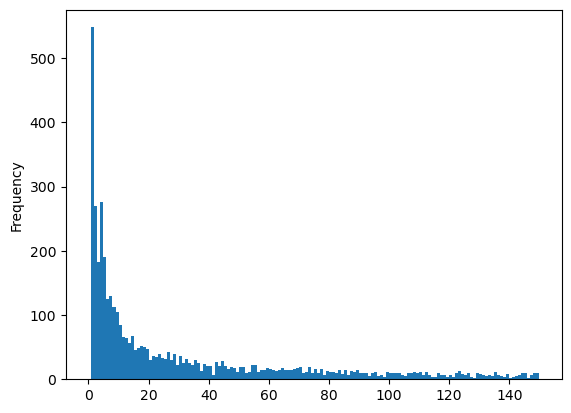

In [83]:
imported_metatriples[imported_metatriples['DOC_N_VALID'] > 0]['DOC_N_VALID'].plot.hist(bins=150, range=[0,150])

In [84]:
## looking at how many metatriples would be left at different cutoffs
imported_metatriples[imported_metatriples['DOC_N_VALID'] > 5].shape
imported_metatriples[imported_metatriples['DOC_N_VALID'] > 10].shape
imported_metatriples[imported_metatriples['DOC_N_VALID'] > 15].shape
imported_metatriples[imported_metatriples['DOC_N_VALID'] > 20].shape
imported_metatriples[imported_metatriples['DOC_N_VALID'] > 100].shape

(6149, 7)

(5592, 7)

(5292, 7)

(5064, 7)

(3663, 7)

After discussion with Andrew Su, we decided to set a threshold of 20 for now. 

I wondered what was going on with the same_as metatriples, so I ran the code block below. Even after the cutoff, it looks like some of these same_as metatriples probably mean "similar effectiveness" which is kind of awkward with the mapped biolink-model predicate of "close_match". 
* orch (organic chemical) same as medd (medical device)? or topp (therapeutic procedure)? 

In [85]:
imported_metatriples[(imported_metatriples['DOC_N_VALID'] > 20) &
                     (imported_metatriples['PREDICATE'] == 'same_as') & 
                     (imported_metatriples['SUBJECT_SEMTYPE'] == 'orch')
                    ]

,SUBJECT_PREFIX,SUBJECT_SEMTYPE,PREDICATE,OBJECT_PREFIX,OBJECT_SEMTYPE,DOC_N,DOC_N_VALID
4015,umls,orch,same_as,umls,orch,2910,450
8039,umls,orch,same_as,umls,hops,190,54
8596,umls,orch,same_as,umls,phsu,350,42
9380,umls,orch,same_as,umls,medd,249,30
9494,umls,orch,same_as,umls,aapp,258,28
9548,umls,orch,same_as,umls,antb,177,28
9636,umls,orch,same_as,umls,topp,226,27


### Pruning for `DOC_N_VALID` > 20 

In [86]:
final_metatriples = imported_metatriples[(imported_metatriples['DOC_N_VALID'] > 20)].copy()
final_metatriples.drop(columns=['DOC_N', 'DOC_N_VALID'], inplace=True)
final_metatriples.shape
final_metatriples[0:3]

(5064, 5)

,SUBJECT_PREFIX,SUBJECT_SEMTYPE,PREDICATE,OBJECT_PREFIX,OBJECT_SEMTYPE
3,umls,bpoc,LOCATION_OF,umls,neop
4,umls,bdsu,LOCATION_OF,umls,aapp
5,umls,bpoc,LOCATION_OF,umls,patf


## Constructing final table with biolink-mappings

In [87]:
## now have to map all SEMMED subject semantic types to biolink categories

final_metatriples = final_metatriples.merge(SEMMED_semtypes[['Abbrev', 'BiolinkMapping']], 
                      how='left', left_on='SUBJECT_SEMTYPE', right_on='Abbrev')

final_metatriples.drop(columns = 'Abbrev', inplace=True)

final_metatriples.columns = [
    'SubjectPrefix', 
    'OriginalSubject', 
    'OriginalPredicate',
    'ObjectPrefix',
    'OriginalObject',
    'BiolinkSubject'
]

In [88]:
final_metatriples

,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject
0,umls,bpoc,LOCATION_OF,umls,neop,GrossAnatomicalStructure
1,umls,bdsu,LOCATION_OF,umls,aapp,AnatomicalEntity
2,umls,bpoc,LOCATION_OF,umls,patf,GrossAnatomicalStructure
3,umls,topp,TREATS,umls,dsyn,Procedure
4,umls,topp,TREATS,umls,neop,Procedure
...,...,...,...,...,...,...
5059,umls,eico,DISRUPTS,umls,dsyn,SmallMolecule
5060,ncbigene,gngm,CONVERTS_TO,umls,nusq,Gene
5061,umls,imft,INTERACTS_WITH,umls,cell,BiologicalEntity
5062,umls,aapp,same_as,umls,topp,Polypeptide


In [89]:
## now have to map all SEMMED object semantic types to biolink categories

final_metatriples = final_metatriples.merge(SEMMED_semtypes[['Abbrev', 'BiolinkMapping']],
                      how='left', left_on='OriginalObject', right_on='Abbrev')

final_metatriples.drop(columns = 'Abbrev', inplace=True)

final_metatriples.columns = [
    'SubjectPrefix', 
    'OriginalSubject', 
    'OriginalPredicate',
    'ObjectPrefix',
    'OriginalObject',
    'BiolinkSubject',
    'BiolinkObject'
]

In [90]:
final_metatriples

,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject
0,umls,bpoc,LOCATION_OF,umls,neop,GrossAnatomicalStructure,Disease
1,umls,bdsu,LOCATION_OF,umls,aapp,AnatomicalEntity,Polypeptide
2,umls,bpoc,LOCATION_OF,umls,patf,GrossAnatomicalStructure,PathologicalProcess
3,umls,topp,TREATS,umls,dsyn,Procedure,Disease
4,umls,topp,TREATS,umls,neop,Procedure,Disease
...,...,...,...,...,...,...,...
5059,umls,eico,DISRUPTS,umls,dsyn,SmallMolecule,Disease
5060,ncbigene,gngm,CONVERTS_TO,umls,nusq,Gene,NucleicAcidEntity
5061,umls,imft,INTERACTS_WITH,umls,cell,BiologicalEntity,Cell
5062,umls,aapp,same_as,umls,topp,Polypeptide,Procedure


In [91]:
## add all biolink predicate / qualifier / inverse stuff
final_metatriples = final_metatriples.merge(
                      SEMMED_predicates,
                      how='left', left_on='OriginalPredicate', right_on='Semmed_in_Data')

final_metatriples.drop(columns = 'Semmed_in_Data', inplace=True)

In [92]:
final_metatriples[0:3]

,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
0,umls,bpoc,LOCATION_OF,umls,neop,GrossAnatomicalStructure,Disease,location_of,None,None,None,located_in,None,None,None
1,umls,bdsu,LOCATION_OF,umls,aapp,AnatomicalEntity,Polypeptide,location_of,None,None,None,located_in,None,None,None
2,umls,bpoc,LOCATION_OF,umls,patf,GrossAnatomicalStructure,PathologicalProcess,location_of,None,None,None,located_in,None,None,None


In [93]:
## check to make sure everything is mapped to Biolink successfully
## should get all empty dataframes

final_metatriples[final_metatriples['BiolinkSubject'].isna()]
final_metatriples[final_metatriples['BiolinkObject'].isna()]

final_metatriples[final_metatriples['BMPred'].isna()]
final_metatriples[final_metatriples['BM_Inv_Pred'].isna()]

,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect


,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect


,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect


,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect


### Adjust Biolink categories based on NCBIGene prefix

There's two ID-namespaces for subject + object: umls + ncbigene. But biolink-model only recognizes NCBIGene as a valid namespace for specific categories, like Gene. 

So we're going to replace the biolink subject / object mapping with Gene whenever it has the NCBIGene prefix...

In [94]:
## looking
final_metatriples[(final_metatriples['SubjectPrefix'] == 'ncbigene') &
                  (final_metatriples['BiolinkSubject'] != 'Gene')]
final_metatriples[(final_metatriples['ObjectPrefix'] == 'ncbigene') &
                  (final_metatriples['BiolinkObject'] != 'Gene')]

,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
146,ncbigene,bacs,PART_OF,umls,aapp,SmallMolecule,Polypeptide,part_of,None,None,None,has_part,None,None,None
149,ncbigene,aapp,STIMULATES,umls,gngm,Polypeptide,Gene,affects,causes,activity_or_abundance,increased,affected_by,caused_by,activity_or_abundance,increased
151,ncbigene,aapp,INTERACTS_WITH,umls,aapp,Polypeptide,Polypeptide,interacts_with,None,None,None,interacts_with,None,None,None
152,ncbigene,aapp,ASSOCIATED_WITH,umls,neop,Polypeptide,Disease,related_to,None,None,None,related_to,None,None,None
190,ncbigene,aapp,PART_OF,umls,virs,Polypeptide,Virus,part_of,None,None,None,has_part,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4971,ncbigene,phsu,INTERACTS_WITH,ncbigene,aapp,SmallMolecule,Polypeptide,interacts_with,None,None,None,interacts_with,None,None,None
4993,ncbigene,imft,ASSOCIATED_WITH,umls,neop,BiologicalEntity,Disease,related_to,None,None,None,related_to,None,None,None
5004,ncbigene,aapp,INHIBITS,umls,nusq,Polypeptide,NucleicAcidEntity,affects,causes,activity_or_abundance,decreased,affected_by,caused_by,activity_or_abundance,decreased
5005,ncbigene,bacs,INTERACTS_WITH,ncbigene,aapp,SmallMolecule,Polypeptide,interacts_with,None,None,None,interacts_with,None,None,None


,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
31,umls,bdsu,LOCATION_OF,ncbigene,aapp,AnatomicalEntity,Polypeptide,location_of,None,None,None,located_in,None,None,None
39,umls,bpoc,LOCATION_OF,ncbigene,aapp,GrossAnatomicalStructure,Polypeptide,location_of,None,None,None,located_in,None,None,None
40,umls,cell,LOCATION_OF,ncbigene,aapp,Cell,Polypeptide,location_of,None,None,None,located_in,None,None,None
63,umls,bacs,PART_OF,ncbigene,aapp,SmallMolecule,Polypeptide,part_of,None,None,None,has_part,None,None,None
101,umls,tisu,LOCATION_OF,ncbigene,aapp,GrossAnatomicalStructure,Polypeptide,location_of,None,None,None,located_in,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5005,ncbigene,bacs,INTERACTS_WITH,ncbigene,aapp,SmallMolecule,Polypeptide,interacts_with,None,None,None,interacts_with,None,None,None
5019,umls,phsf,PRODUCES,ncbigene,imft,PhysiologicalProcess,BiologicalEntity,produces,None,None,None,produced_by,None,None,None
5032,umls,eico,INHIBITS,ncbigene,aapp,SmallMolecule,Polypeptide,affects,causes,activity_or_abundance,decreased,affected_by,caused_by,activity_or_abundance,decreased
5034,umls,topp,USES,ncbigene,phsu,Procedure,SmallMolecule,has_input,None,None,None,is_input_of,None,None,None


In [95]:
## Next, mutate the metatriples with ncbigene prefix so their Biolink categories are Gene 
for index in final_metatriples.index:
    if (final_metatriples.loc[index,'SubjectPrefix'] == 'ncbigene'):
        final_metatriples.loc[index,'BiolinkSubject'] = 'Gene'
    if final_metatriples.loc[index,'ObjectPrefix'] == 'ncbigene':
        final_metatriples.loc[index,'BiolinkObject'] = 'Gene'

In [96]:
## double-checking: should now get empty dataframes
final_metatriples[(final_metatriples['SubjectPrefix'] == 'ncbigene') &
                (final_metatriples['BiolinkSubject'] != 'Gene')]
final_metatriples[(final_metatriples['ObjectPrefix'] == 'ncbigene') &
                (final_metatriples['BiolinkObject'] != 'Gene')]

,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect


,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect


## Generate operation yaml!

# PAUSE

Review / test the code below carefully!

* If needed, change the code within the functions below to change the x-bte annotations that are made...
  * review the prefix-handling code! This is to handle ncbigene ID-namespace for some metatriples
  * review the qualifier-generating code! Currently it's very simple because all operations with qualifiers have the same set: qualified_predicate, an aspect_qualifier, and a direction_qualifier...
* the yaml created below refers to umls-subj, umls-obj, ncbigene-subj, ncbigene-obj...those are specified [here close to the bottom](https://github.com/NCATS-Tangerine/translator-api-registry/blob/master/semmeddb/version_without_operations.yaml)

### function for forward operations

In [97]:
## will use variables set in first section's config
## original direction: subject -> object

def generate_forward_op(
    subj_prefix, obj_prefix,
    original_subj, original_pred, original_obj,
    biolink_subj, biolink_pred, 
    biolink_qualified_pred, biolink_obj_asp, biolink_obj_direct,
    biolink_obj):
    
    ## get biolink-model spelling for prefixes
    if subj_prefix == 'umls':
        biolink_subj_prefix = 'UMLS'
    else:
        biolink_subj_prefix = 'NCBIGene'
        
    if obj_prefix == 'umls':
        biolink_obj_prefix = 'UMLS'
    else:
        biolink_obj_prefix = 'NCBIGene'
    
    ## create the keys for the operation names
    if (subj_prefix == 'umls') and (obj_prefix == 'umls'):
        normal_op_name = f'{original_subj}-{original_pred}-{original_obj}'
    else:
        normal_op_name = f'{original_subj},{subj_prefix}-{original_pred}-{original_obj},{obj_prefix}'
    
    temp = {
        ## original direction: subject -> object
        normal_op_name: [
            {
                'supportBatch': True,
                'useTemplating': True,
                'inputs': [
                    {
                        'id': biolink_subj_prefix,
                        'semantic': biolink_subj  ## input is subject!
                    }
                ],
                ## notice that subject.{subj_prefix} only works because 
                ##   the API fields are spelled 'umls' and 'ncbigene' too
                ## if this changes, it'll need adjustment
                'requestBody': {
                    'body': {
                        'q': '{{ queryInputs }}',
                        'scopes': f'subject.{subj_prefix}'
                    }
                },
                ## notice that object.{obj_prefix} only works because 
                ##   the API fields are spelled 'umls' and 'ncbigene' too
                ## if this changes, it'll need adjustment
                'parameters': {
                    'fields': f'object.{obj_prefix},predication.pmid,'
                               'predication.sentence,subject.name,object.name',
                    'size': POST_size,
                    'filter': f'predicate:{original_pred} AND '
                              f'object.semantic_type_abbreviation:{original_obj} AND '
                              f'_exists_:object.{obj_prefix} AND '
                              f'pmid_count:>{pmid_count}'
                },
                'outputs': [
                    {
                        'id': biolink_obj_prefix,
                        'semantic': biolink_obj  ## output is object
                    }
                ],
                'predicate': biolink_pred,
                'source': doublequote('infores:semmeddb'),
                'response_mapping': {
                    ## matches output as object
                    ## so umls-obj and ncbigene-obj are the response-mappings generated
                    "$ref": f'#/components/x-bte-response-mapping/{obj_prefix}-obj'  
                }
            }
        ]
    }
    
    ## if there is a qualified_predicate
    ##   there's a set of qualifiers that also has obj aspect and obj direction
    if biolink_qualified_pred:
        temp[normal_op_name][0]['qualifiers'] = {
            'qualified_predicate': biolink_qualified_pred,
            'object_aspect_qualifier': biolink_obj_asp,
            'object_direction_qualifier': biolink_obj_direct
        }
        
    return temp

In [98]:
## testing: umls - umls
generate_forward_op(
    'umls', 'umls',
    'bpoc', 'LOCATION_OF', 'neop',
    'GrossAnatomicalStructure', 'location_of', 
     None, None, None,
    'Disease')

{'bpoc-LOCATION_OF-neop': [{'supportBatch': True,
   'useTemplating': True,
   'inputs': [{'id': 'UMLS', 'semantic': 'GrossAnatomicalStructure'}],
   'requestBody': {'body': {'q': '{{ queryInputs }}',
     'scopes': 'subject.umls'}},
   'parameters': {'fields': 'object.umls,predication.pmid,predication.sentence,subject.name,object.name',
    'size': 1000,
    'filter': 'predicate:LOCATION_OF AND object.semantic_type_abbreviation:neop AND _exists_:object.umls AND pmid_count:>3'},
   'outputs': [{'id': 'UMLS', 'semantic': 'Disease'}],
   'predicate': 'location_of',
   'source': 'infores:semmeddb',
   'response_mapping': {'$ref': '#/components/x-bte-response-mapping/umls-obj'}}]}

In [99]:
## testing: ncbigene - umls
generate_forward_op(
    'ncbigene', 'umls',
    'gngm', 'ASSOCIATED_WITH', 'neop',
    'Gene', 'related_to', 
     None, None, None,
    'Disease')

{'gngm,ncbigene-ASSOCIATED_WITH-neop,umls': [{'supportBatch': True,
   'useTemplating': True,
   'inputs': [{'id': 'NCBIGene', 'semantic': 'Gene'}],
   'requestBody': {'body': {'q': '{{ queryInputs }}',
     'scopes': 'subject.ncbigene'}},
   'parameters': {'fields': 'object.umls,predication.pmid,predication.sentence,subject.name,object.name',
    'size': 1000,
    'filter': 'predicate:ASSOCIATED_WITH AND object.semantic_type_abbreviation:neop AND _exists_:object.umls AND pmid_count:>3'},
   'outputs': [{'id': 'UMLS', 'semantic': 'Disease'}],
   'predicate': 'related_to',
   'source': 'infores:semmeddb',
   'response_mapping': {'$ref': '#/components/x-bte-response-mapping/umls-obj'}}]}

In [100]:
## testing: umls - ncbigene
generate_forward_op(
    'umls', 'ncbigene',
    'aapp', 'STIMULATES', 'gngm',
    'Polypeptide', 'affects', 
    'causes', 'activity_or_abundance', 'increased',
    'Gene')

{'aapp,umls-STIMULATES-gngm,ncbigene': [{'supportBatch': True,
   'useTemplating': True,
   'inputs': [{'id': 'UMLS', 'semantic': 'Polypeptide'}],
   'requestBody': {'body': {'q': '{{ queryInputs }}',
     'scopes': 'subject.umls'}},
   'parameters': {'fields': 'object.ncbigene,predication.pmid,predication.sentence,subject.name,object.name',
    'size': 1000,
    'filter': 'predicate:STIMULATES AND object.semantic_type_abbreviation:gngm AND _exists_:object.ncbigene AND pmid_count:>3'},
   'outputs': [{'id': 'NCBIGene', 'semantic': 'Gene'}],
   'predicate': 'affects',
   'source': 'infores:semmeddb',
   'response_mapping': {'$ref': '#/components/x-bte-response-mapping/ncbigene-obj'},
   'qualifiers': {'qualified_predicate': 'causes',
    'object_aspect_qualifier': 'activity_or_abundance',
    'object_direction_qualifier': 'increased'}}]}

In [101]:
## testing: ncbigene - ncbigene
generate_forward_op(
    'ncbigene', 'ncbigene',
    'gngm', 'STIMULATES', 'gngm',
    'Gene', 'affects', 
    'causes', 'activity_or_abundance', 'increased',
    'Gene')

{'gngm,ncbigene-STIMULATES-gngm,ncbigene': [{'supportBatch': True,
   'useTemplating': True,
   'inputs': [{'id': 'NCBIGene', 'semantic': 'Gene'}],
   'requestBody': {'body': {'q': '{{ queryInputs }}',
     'scopes': 'subject.ncbigene'}},
   'parameters': {'fields': 'object.ncbigene,predication.pmid,predication.sentence,subject.name,object.name',
    'size': 1000,
    'filter': 'predicate:STIMULATES AND object.semantic_type_abbreviation:gngm AND _exists_:object.ncbigene AND pmid_count:>3'},
   'outputs': [{'id': 'NCBIGene', 'semantic': 'Gene'}],
   'predicate': 'affects',
   'source': 'infores:semmeddb',
   'response_mapping': {'$ref': '#/components/x-bte-response-mapping/ncbigene-obj'},
   'qualifiers': {'qualified_predicate': 'causes',
    'object_aspect_qualifier': 'activity_or_abundance',
    'object_direction_qualifier': 'increased'}}]}

In [102]:
## get an example to check on 
final_metatriples[(final_metatriples['SubjectPrefix'] == 'ncbigene') &
                  (final_metatriples['ObjectPrefix'] == 'ncbigene')]

,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
265,ncbigene,aapp,STIMULATES,ncbigene,gngm,Gene,Gene,affects,causes,activity_or_abundance,increased,affected_by,caused_by,activity_or_abundance,increased
336,ncbigene,gngm,STIMULATES,ncbigene,gngm,Gene,Gene,affects,causes,activity_or_abundance,increased,affected_by,caused_by,activity_or_abundance,increased
343,ncbigene,aapp,INTERACTS_WITH,ncbigene,aapp,Gene,Gene,interacts_with,None,None,None,interacts_with,None,None,None
473,ncbigene,gngm,INTERACTS_WITH,ncbigene,aapp,Gene,Gene,interacts_with,None,None,None,interacts_with,None,None,None
478,ncbigene,gngm,INTERACTS_WITH,ncbigene,gngm,Gene,Gene,interacts_with,None,None,None,interacts_with,None,None,None
489,ncbigene,gngm,INHIBITS,ncbigene,gngm,Gene,Gene,affects,causes,activity_or_abundance,decreased,affected_by,caused_by,activity_or_abundance,decreased
516,ncbigene,aapp,INTERACTS_WITH,ncbigene,gngm,Gene,Gene,interacts_with,None,None,None,interacts_with,None,None,None
566,ncbigene,aapp,COEXISTS_WITH,ncbigene,gngm,Gene,Gene,coexists_with,None,None,None,coexists_with,None,None,None
591,ncbigene,bacs,PART_OF,ncbigene,aapp,Gene,Gene,part_of,None,None,None,has_part,None,None,None
659,ncbigene,aapp,INHIBITS,ncbigene,aapp,Gene,Gene,affects,causes,activity_or_abundance,decreased,affected_by,caused_by,activity_or_abundance,decreased


### function for reverse operations

In [103]:
## will use variables set in first section's config
## reverse direction: object -> subject

def generate_reverse_op(
    subj_prefix, obj_prefix,
    original_subj, original_pred, original_obj,
    biolink_subj, 
    ## NOTICE THE INVERSES USED HERE
    biolink_inverse_pred, 
    biolink_inverse_qualified_pred, biolink_inverse_subj_asp, biolink_inverse_subj_direct,
    biolink_obj):

    ## get biolink-model spelling for prefixes
    if subj_prefix == 'umls':
        biolink_subj_prefix = 'UMLS'
    else:
        biolink_subj_prefix = 'NCBIGene'
        
    if obj_prefix == 'umls':
        biolink_obj_prefix = 'UMLS'
    else:
        biolink_obj_prefix = 'NCBIGene'
    
    ## create the keys for the operation names
    if (subj_prefix == 'umls') and (obj_prefix == 'umls'):
        rev_op_name = f'{original_subj}-{original_pred}-{original_obj}-rev'
    else:
        rev_op_name = f'{original_subj},{subj_prefix}-{original_pred}-{original_obj},{obj_prefix}-rev'

    temp = {
        ## reverse direction: object -> subject
        rev_op_name: [
            {
                'supportBatch': True,
                'useTemplating': True,
                'inputs': [
                    {
                        'id': biolink_obj_prefix,
                        'semantic': biolink_obj  ## input is object!
                    }
                ],
                ## notice that object.{obj_prefix} only works because 
                ##   the API fields are spelled 'umls' and 'ncbigene' too
                ## if this changes, it'll need adjustment
                'requestBody': {
                    'body': {
                        'q': '{{ queryInputs }}',
                        'scopes': f'object.{obj_prefix}'
                    }
                },
                ## notice that subject.{subj_prefix} only works because 
                ##   the API fields are spelled 'umls' and 'ncbigene' too
                ## if this changes, it'll need adjustment
                'parameters': {
                    'fields': f'subject.{subj_prefix},predication.pmid,'
                               'predication.sentence,subject.name,object.name',
                    'size': POST_size,
                    'filter': f'predicate:{original_pred} AND '
                              f'subject.semantic_type_abbreviation:{original_subj} AND '
                              f'_exists_:subject.{subj_prefix} AND '
                              f'pmid_count:>{pmid_count}'
                },        
                'outputs': [
                    {
                        'id': biolink_subj_prefix,
                        'semantic': biolink_subj  ## output is subject
                    }
                ],
                'predicate': biolink_inverse_pred,  ## use inverse pred!
                'source': doublequote('infores:semmeddb'),
                'response_mapping': {
                    ## matches output as object
                    ## so umls-obj and ncbigene-obj are the response-mappings generated
                    "$ref": f'#/components/x-bte-response-mapping/{subj_prefix}-subj'
                }
            }
        ]
    }
    
    ## if there is a qualified_predicate
    ##   there's a set of qualifiers that also has subj aspect and subj direction
    if biolink_inverse_qualified_pred:
        temp[rev_op_name][0]['qualifiers'] = {
            'qualified_predicate': biolink_inverse_qualified_pred,  ## use inverse pred!
            ## use subject qualifiers
            'subject_aspect_qualifier': biolink_inverse_subj_asp,         
            'subject_direction_qualifier': biolink_inverse_subj_direct   
        }
    
    return temp

In [104]:
## get an example to check on 
final_metatriples[(final_metatriples['SubjectPrefix'] == 'umls') &
                  (final_metatriples['ObjectPrefix'] == 'umls')]

,SubjectPrefix,OriginalSubject,OriginalPredicate,ObjectPrefix,OriginalObject,BiolinkSubject,BiolinkObject,BMPred,BMQualPred,BMObjAsp,BMObjDirect,BM_Inv_Pred,BM_Inv_QualPred,BM_Inv_SubjAsp,BM_Inv_SubjDirect
0,umls,bpoc,LOCATION_OF,umls,neop,GrossAnatomicalStructure,Disease,location_of,None,None,None,located_in,None,None,None
1,umls,bdsu,LOCATION_OF,umls,aapp,AnatomicalEntity,Polypeptide,location_of,None,None,None,located_in,None,None,None
2,umls,bpoc,LOCATION_OF,umls,patf,GrossAnatomicalStructure,PathologicalProcess,location_of,None,None,None,located_in,None,None,None
3,umls,topp,TREATS,umls,dsyn,Procedure,Disease,treats_or_applied_or_studied_to_treat,None,None,None,"subject_of_treatment,_application,_or_study_fo...",None,None,None
4,umls,topp,TREATS,umls,neop,Procedure,Disease,treats_or_applied_or_studied_to_treat,None,None,None,"subject_of_treatment,_application,_or_study_fo...",None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5057,umls,irda,COEXISTS_WITH,umls,phsu,DiagnosticAid,SmallMolecule,coexists_with,None,None,None,coexists_with,None,None,None
5059,umls,eico,DISRUPTS,umls,dsyn,SmallMolecule,Disease,disrupts,None,None,None,disrupted_by,None,None,None
5061,umls,imft,INTERACTS_WITH,umls,cell,BiologicalEntity,Cell,interacts_with,None,None,None,interacts_with,None,None,None
5062,umls,aapp,same_as,umls,topp,Polypeptide,Procedure,close_match,None,None,None,close_match,None,None,None


In [105]:
## testing: umls - umls
generate_reverse_op(
    'umls', 'umls',
    'bpoc', 'LOCATION_OF', 'neop',
    'GrossAnatomicalStructure', 'located_in', 
     None, None, None,
    'Disease')

{'bpoc-LOCATION_OF-neop-rev': [{'supportBatch': True,
   'useTemplating': True,
   'inputs': [{'id': 'UMLS', 'semantic': 'Disease'}],
   'requestBody': {'body': {'q': '{{ queryInputs }}',
     'scopes': 'object.umls'}},
   'parameters': {'fields': 'subject.umls,predication.pmid,predication.sentence,subject.name,object.name',
    'size': 1000,
    'filter': 'predicate:LOCATION_OF AND subject.semantic_type_abbreviation:bpoc AND _exists_:subject.umls AND pmid_count:>3'},
   'outputs': [{'id': 'UMLS', 'semantic': 'GrossAnatomicalStructure'}],
   'predicate': 'located_in',
   'source': 'infores:semmeddb',
   'response_mapping': {'$ref': '#/components/x-bte-response-mapping/umls-subj'}}]}

In [106]:
## testing: ncbigene - umls
generate_reverse_op(
    'ncbigene', 'umls',
    'gngm', 'ASSOCIATED_WITH', 'neop',
    'Gene', 'related_to', 
     None, None, None,
    'Disease')

{'gngm,ncbigene-ASSOCIATED_WITH-neop,umls-rev': [{'supportBatch': True,
   'useTemplating': True,
   'inputs': [{'id': 'UMLS', 'semantic': 'Disease'}],
   'requestBody': {'body': {'q': '{{ queryInputs }}',
     'scopes': 'object.umls'}},
   'parameters': {'fields': 'subject.ncbigene,predication.pmid,predication.sentence,subject.name,object.name',
    'size': 1000,
    'filter': 'predicate:ASSOCIATED_WITH AND subject.semantic_type_abbreviation:gngm AND _exists_:subject.ncbigene AND pmid_count:>3'},
   'outputs': [{'id': 'NCBIGene', 'semantic': 'Gene'}],
   'predicate': 'related_to',
   'source': 'infores:semmeddb',
   'response_mapping': {'$ref': '#/components/x-bte-response-mapping/ncbigene-subj'}}]}

In [107]:
## testing: umls - ncbigene
generate_reverse_op(
    'umls', 'ncbigene',
    'aapp', 'STIMULATES', 'gngm',
    'Polypeptide', 'affected_by', 
    'caused_by', 'activity_or_abundance', 'increased',
    'Gene')

{'aapp,umls-STIMULATES-gngm,ncbigene-rev': [{'supportBatch': True,
   'useTemplating': True,
   'inputs': [{'id': 'NCBIGene', 'semantic': 'Gene'}],
   'requestBody': {'body': {'q': '{{ queryInputs }}',
     'scopes': 'object.ncbigene'}},
   'parameters': {'fields': 'subject.umls,predication.pmid,predication.sentence,subject.name,object.name',
    'size': 1000,
    'filter': 'predicate:STIMULATES AND subject.semantic_type_abbreviation:aapp AND _exists_:subject.umls AND pmid_count:>3'},
   'outputs': [{'id': 'UMLS', 'semantic': 'Polypeptide'}],
   'predicate': 'affected_by',
   'source': 'infores:semmeddb',
   'response_mapping': {'$ref': '#/components/x-bte-response-mapping/umls-subj'},
   'qualifiers': {'qualified_predicate': 'caused_by',
    'subject_aspect_qualifier': 'activity_or_abundance',
    'subject_direction_qualifier': 'increased'}}]}

In [108]:
## testing: ncbigene - ncbigene
generate_reverse_op(
    'ncbigene', 'ncbigene',
    'gngm', 'STIMULATES', 'gngm',
    'Gene', 'affected_by', 
    'caused_by', 'activity_or_abundance', 'increased',
    'Gene')

{'gngm,ncbigene-STIMULATES-gngm,ncbigene-rev': [{'supportBatch': True,
   'useTemplating': True,
   'inputs': [{'id': 'NCBIGene', 'semantic': 'Gene'}],
   'requestBody': {'body': {'q': '{{ queryInputs }}',
     'scopes': 'object.ncbigene'}},
   'parameters': {'fields': 'subject.ncbigene,predication.pmid,predication.sentence,subject.name,object.name',
    'size': 1000,
    'filter': 'predicate:STIMULATES AND subject.semantic_type_abbreviation:gngm AND _exists_:subject.ncbigene AND pmid_count:>3'},
   'outputs': [{'id': 'NCBIGene', 'semantic': 'Gene'}],
   'predicate': 'affected_by',
   'source': 'infores:semmeddb',
   'response_mapping': {'$ref': '#/components/x-bte-response-mapping/ncbigene-subj'},
   'qualifiers': {'qualified_predicate': 'caused_by',
    'subject_aspect_qualifier': 'activity_or_abundance',
    'subject_direction_qualifier': 'increased'}}]}

### generating all operations

In [109]:
def generate_all_operations(metatriple_df):
    op_tracking = set()
    
    saved = dict()
    ## iterate through rows of metatriple dataframe
    for row in metatriple_df.itertuples(index = False):
        
        ## forward: only make operation if it's not going to be a dupe
        ##  dupes happen because we don't set the SEMMED semantic type of the subject (input / starting point)
        ##  and multiple subject SEMMED semantic types can match 1 Biolink-Subject-category
        ##  variables to have in common are the prefixes, semmed predicate, semmed object
        forward_op_record = f"{row.BiolinkSubject},{row.SubjectPrefix}-{row.OriginalPredicate}-{row.OriginalObject},{row.ObjectPrefix}"
        
        if forward_op_record not in op_tracking:
            op_tracking.add(forward_op_record)
            
            saved.update(generate_forward_op(subj_prefix = row.SubjectPrefix,
                                             obj_prefix = row.ObjectPrefix,
                                             original_subj = row.OriginalSubject,
                                             original_pred = row.OriginalPredicate,
                                             original_obj = row.OriginalObject,
                                             biolink_subj = row.BiolinkSubject,
                                             biolink_pred = row.BMPred,
                                             biolink_qualified_pred = row.BMQualPred,
                                             biolink_obj_asp = row.BMObjAsp,
                                             biolink_obj_direct = row.BMObjDirect,
                                             biolink_obj = row.BiolinkObject
                                            ))        
        
        ## reverse: make operation if it's not going to be a dupe
        ##  dupes happen because we don't set the SEMMED semantic type of the object (input / starting point)
        ##  and multiple object SEMMED semantic types can match 1 Biolink-Object-category
        ##  variables to have in common are the prefixes, semmed predicate, semmed subject
        reverse_op_record = f"rev-{row.BiolinkObject},{row.ObjectPrefix}-{row.OriginalPredicate}-{row.OriginalSubject},{row.SubjectPrefix}"
        
        if reverse_op_record not in op_tracking:
            op_tracking.add(reverse_op_record)
            saved.update(generate_reverse_op(subj_prefix = row.SubjectPrefix,
                                             obj_prefix = row.ObjectPrefix,
                                             original_subj = row.OriginalSubject,
                                             original_pred = row.OriginalPredicate,
                                             original_obj = row.OriginalObject,
                                             biolink_subj = row.BiolinkSubject,
                                             biolink_inverse_pred = row.BM_Inv_Pred,
                                             biolink_inverse_qualified_pred = row.BM_Inv_QualPred,
                                             biolink_inverse_subj_asp = row.BM_Inv_SubjAsp,
                                             biolink_inverse_subj_direct = row.BM_Inv_SubjDirect,
                                             biolink_obj = row.BiolinkObject
                                             ))           
            
    final = {"x-bte-kgs-operations": saved}
    return final

Get the file made!

In [110]:
kgs_operations = generate_all_operations(final_metatriples)

In [111]:
len(kgs_operations['x-bte-kgs-operations'])

4767

In [112]:
## double-check qualifier + rev operation is written properly?
for i in kgs_operations['x-bte-kgs-operations'].keys():
    if ('INHIBITS' in i) and ('rev' in i) and ('ncbigene' in i):
        print(i)
        pprint.pprint(kgs_operations['x-bte-kgs-operations'][i], sort_dicts = False)
        break

orch,umls-INHIBITS-gngm,ncbigene-rev
[{'supportBatch': True,
  'useTemplating': True,
  'inputs': [{'id': 'NCBIGene', 'semantic': 'Gene'}],
  'requestBody': {'body': {'q': '{{ queryInputs }}',
                           'scopes': 'object.ncbigene'}},
  'parameters': {'fields': 'subject.umls,predication.pmid,predication.sentence,subject.name,object.name',
                 'size': 1000,
                 'filter': 'predicate:INHIBITS AND '
                           'subject.semantic_type_abbreviation:orch AND '
                           '_exists_:subject.umls AND pmid_count:>3'},
  'outputs': [{'id': 'UMLS', 'semantic': 'SmallMolecule'}],
  'predicate': 'affected_by',
  'source': 'infores:semmeddb',
  'response_mapping': {'$ref': '#/components/x-bte-response-mapping/umls-subj'},
  'qualifiers': {'qualified_predicate': 'caused_by',
                 'subject_aspect_qualifier': 'activity_or_abundance',
                 'subject_direction_qualifier': 'decreased'}}]


In [114]:
## double-check qualifier + rev operation is written properly?
for i in kgs_operations['x-bte-kgs-operations'].keys():
    if ('sbst' in i):
        print(i)
        pprint.pprint(kgs_operations['x-bte-kgs-operations'][i], sort_dicts = False)
        break

sbst-CAUSES-patf
[{'supportBatch': True,
  'useTemplating': True,
  'inputs': [{'id': 'UMLS', 'semantic': 'ChemicalEntity'}],
  'requestBody': {'body': {'q': '{{ queryInputs }}', 'scopes': 'subject.umls'}},
  'parameters': {'fields': 'object.umls,predication.pmid,predication.sentence,subject.name,object.name',
                 'size': 1000,
                 'filter': 'predicate:CAUSES AND '
                           'object.semantic_type_abbreviation:patf AND '
                           '_exists_:object.umls AND pmid_count:>3'},
  'outputs': [{'id': 'UMLS', 'semantic': 'PathologicalProcess'}],
  'predicate': 'causes',
  'source': 'infores:semmeddb',
  'response_mapping': {'$ref': '#/components/x-bte-response-mapping/umls-obj'}}]


# PAUSE

* it's cool how condensed the operations become, due to the way querying is done (keeping track of not creating duplicated operations using the sets in generate_all_operations function)
* set where to download the yamls in the code chunks below
  * operations_path
  * list_path

In [115]:
yaml.boolean_representation = ['False', 'True']

## this path was set in the config section at the beginning
yaml.dump(kgs_operations, operations_path)

Wait a sec! Need the operations list too!

In [116]:
def generate_kgs_operations_list(operations_dict):
    kgs_op_list = []
    for key in operations_dict.keys():
        kgs_op_list.append( {"$ref": f"#/components/x-bte-kgs-operations/{key}"} )
    final2 = {"x-bte-kgs-operations": kgs_op_list}
    return final2

In [117]:
operations_list = generate_kgs_operations_list(kgs_operations['x-bte-kgs-operations'])

In [118]:
yaml.dump(operations_list, list_path)

# PAUSE

* now the yaml segments downloaded have to be indented manually and inserted into the correct sections of the smartapi yaml...
  * It's easier to do with an IDE like Visual Code studio where one can select large sections of text
  * the amount of indent to do and where to put things is specified in the [yaml that acts as a template](https://github.com/NCATS-Tangerine/translator-api-registry/blob/master/semmeddb/version_without_operations.yaml)
  * the finished file is meant to be [here](https://github.com/NCATS-Tangerine/translator-api-registry/blob/master/semmeddb/smartapi.yaml) so one could select-paste the sections directly there

## defunct: Notes on previously removed SEMMED semantic types

* amas: (Amino Acid Sequence) looks like protein "domains". Examples: Nuclear Export Signals, DNA Binding Domain
* acty (Activity) Examples: War, Retirement, Euthanasia, Lifting
* dora (Daily or Recreational Activity) Examples: Physical activity, Light Exercise, Relaxation
* edac (Educational Activity) Examples: Training, Medical Residencies
* gora (Governmental or Regulatory Activity) Examples: Health Care Reform, Advisory Committees
* hlca (Health Care Activity) Examples: follow-up, Diagnosis
* mcha (Machine Activity) Examples: Refridgeration, Neural Network Simulation
* ocac (Occupational Activity) Examples: Promotion, Work, Mining
* resa (Research Activity) Examples: Clinical Trials, research study
* aggp (Age Group) Examples: Infant, Child, Adult, Elderly
* famg (Family Group) Examples: spouse, Sister, Foster Parent
* podg (Patient or Disabled Group) Examples: Patients
* prog (Professional or Occupational Group) Examples: Administrators, Employee, Author
* algae (Algae)
* invt (Invertebrate)
* orgm (Organism)
* rich (Rickettsia or Chlamydia)
* amph (Amphibian) Examples: Toad, Bufo boreas, Anura
* anim (Animal) Examples: Animals, Laboratory /  Control Animal
* arch (Archaeon) Examples: Archaea, halophilic bacteria, Thermoplasma acidophilum
* bact (Bacterium) Examples: Escherichia coli, Salmonella, Borrelia burgdorferi
* bdsu (Body Substance) too general. Examples: Urine, Milk, Lymph, Urine specimen
* bdsy (Body System) too general. Examples: hypothalamic-pituitary-adrenal axis, Neurosecretory Systems
* bird (Bird) Examples: Geese, Passeriformes, Raptors
* blor (Body Location or Region) too general. Examples: Hepatic, Lysosomal, Cytoplasmic
* bmod (Biomedical Occupation or Discipline) Examples: Medicine, Dentistry, Midwifery
* bsoj (Body Space or Junction) too general. Examples: Compartments, Synapses, Cistern
* chvf (Chemical Viewed Functionally) too general. Examples: inhibitors, antagonists, Agent
* chvs (Chemical Viewed Structurally) too general. Examples: particle, solid state, vapor
* euka (Eukaryote) Examples: Wasps, Protozoan parasite
* ffas (Fully Formed Anatomical Structure) Examples: Carcass
* fish (Fish) Examples: Eels, Fishes, Electric Fish
* fngs (Fungus) Examples: Saccharomyces cerevisiae, Alternaria brassicicola, fungus
* humn (Human) Examples: Family, Patients, Males
* irda (Indicator, Reagent, or Diagnostic Aid) Examples: Fluorescent Probes, Chelating Agents
* mamm (Mammal) Examples: Rattus norvegicus, Felis catus, Mus
* ocdi (Occupation or Discipline) Examples: Science, Politics
* plnt (Plant) Examples: Chrysanthemum x morifolium, Pollen, Oryza sativa
* rept (Reptile) Examples: Snakes, Turtles, Reptiles
* sbst (Substance) too general. Examples: Materials, Plastics, Photons, Substance
* virs (Virus) Examples: Herpesvirus 4, Human / GB virus C / Herpesviridae
* vtbt (Vertebrate) Examples: Vertebrates / Poikilotherm, NOS
* anst (Anatomical Structure) Examples: Entire fetus, Whole body, Cadaver
* bhvr (Behavior) too general. Examples: Sexuality, Nest Building, Behavioral phenotype
* inbe (Individual Behavior) too general. Examples: impulsivity, Habits, Performance
* menp (Mental Process) too general. Examples: mind control, Learning, experience
* socb (Social Behavior) too general. Examples: Communication, Gestures, Marriage
* biof (Biologic Function) too general. Examples: dose-response relationship, Pharmacodynamics, Anabolism
* eehu (Environmental Effect of Humans) too general. Examples: Sewage, Pollution, Smoke
* hcpp (Human-caused Phenomenon or Process) too general. Now not in API. Examples: particle beam, Conferences, Victimization
* lbtr (Laboratory or Test Result) too general. Examples: False Positive Reactions, Bone Density, Serum Calcium Level
* npop (Natural Phenomenon or Process) too general. Examples: Floods, Fluorescence, Freezing
* phpr (Phenomenon or Process) too general. Examples: Disasters, Acceleration, Feedback
* bodm (Biomedical or Dental Material) too general. Examples: Pill, Gel, Talc, calcium phosphate
* drdd (Drug Delivery Device) too general. Examples: Epipen, Skin Patch, Lilly cyanide antidote kit
* medd (Medical Device) too general. Examples: Implants / Denture, Overlay / Silicone gel implant / Swab
* resd (Research Device) too general. Examples: Study models, Slide
* emst (Embryonic Structure) Examples: Chick Embryo, Blastocyst structure, Placenta
* tisu (Tissue) Examples: Tissue specimen, Blood, Human tissue, Mucous Membrane
* genf (Genetic Function) too general. Examples: Transcription, Genetic / Transcriptional Activation / Recombination, Genetic
* chem (Chemical) too general. Examples: Chemicals, Acids, Ligands, Ozone
* clas (Classification) too general. Examples: Research Diagnostic Criteria, Group C
* ftcn (Functional Concept) too general. Examples: Techniques, Intravenous Route of Drug Administration
* idcn (Idea or Concept) too general. Examples: Significant, subject, Data, Owner
* qlco (Qualitative Concept) too general. Examples: Effect, Associated with, Advanced phase
* qnco (Quantitative Concept) too general. Examples: Calibration, occurrence, degrees Celsius
* rnlw (Regulation or Law) too general. Examples: Medicare, Medicaid, regulatory
* spco (Spatial Concept) too general. Examples: Structure, Longitudinal, Asymmetry
* tmco (Temporal Concept) too general. Examples: New, /period, 24 Hours
* clna (Clinical Attribute) too general. Examples: response, Renin secretion, BAND PATTERN
* lbpr (Laboratory Procedure) too general. Examples: Western Blot, Radioimmunoassay, Staining method
* mbrt (Molecular Biology Research Technique) too general. Examples: Polymerase Chain Reaction / Blotting, Northern
* elii (Element, Ion, or Isotope) too general. Examples: Atom, Aluminum, Superoxides
* emod (Experimental Model of Disease) too general. Examples: Experimental Autoimmune Encephalomyelitis, Rodent Model
* rcpt (Receptor) too general. Examples: Binding Sites / Receptors, Metabotropic Glutamate
* evnt (Event) too general. Now not in API. Examples: Stressful Events
* fndg (Finding) too general. Examples: spinal cord; lesion, Normal birth weight, Sedentary job
* geoa (Geographic Area) too general. Examples: Country, Canada
* grup (Group) too general. Examples: Human, Individual
* hcro (Health Care Related Organization) too general. Examples: Hospitals, Health System
* orgt (Organization) too general. Examples: United Nations, Organization administrative structures
* pros (Professional Society) too general. Examples: Professional Organizations, American Nurses' Association
* shro (Self-help or Relief Organization) too general. Examples: Social Welfare, Support Groups
* inpr (Intellectual Product) too general. Examples: Methodology, Study models
* mnob (Manufactured Object) too general. Examples: Glass, Manuals
* mosq (Molecular Sequence) too general. Now not in API. Examples: Genetic Code
* nusq (Nucleotide Sequence) too general. Examples: Base Sequence, DNA Sequence, 22q11
* orga (Organism Attribute) too general. Examples: Ability, Body Composition
* popg (Population Group) too general. Examples: Male population group, Woman